# Problem overview

This notebook studies adversarial attacks (and simple defenses) on CNN and Vision Transformer (ViT) models. The objectives:

- Implement fast gradient-based attacks (FGSM, PGD) and evaluate their effect on both CNN and ViT classifiers.
- Compare model robustness and visualize adversarial examples.
- Optionally show simple defenses (e.g., adversarial training or input preprocessing).


# Mathematical foundation (concise)

- Given classifier f_\theta(x) producing logits, cross-entropy loss \(\ell(f_\theta(x), y)\).
- FGSM: one-step attack using gradient sign:

\[ x_{adv} = x + \epsilon \cdot \text{sign}(\nabla_x \ell(f_\theta(x), y)) \]

- PGD: iterative projected gradient descent with step size \(\alpha\) and projection onto \(\ell_\infty\) ball of radius \(\epsilon\):

\[ x^{t+1} = \text{Proj}_{\|x - x_0\|_\infty \le \epsilon}\left(x^t + \alpha \cdot \text{sign}(\nabla_x \ell(f_\theta(x^t), y))\right) \]

- Robust accuracy: accuracy of model on adversarial perturbations.


# Implementation notes & practical tips

- Normalize inputs consistently (use the same mean/std for both clean and adversarial images).
- Clip perturbed images to valid pixel range after each update.
- For ViT, patch embeddings make perturbations behave differently; consider per-patch visualization.
- When reporting results, show clean accuracy and robust accuracy at different \(\epsilon\) values.

# Suggested experiments

1. Compare FGSM vs PGD across multiple \(\epsilon\) values.
2. Compare CNN vs ViT robust accuracy at same \(\epsilon\).
3. Run adversarial training (PGD adversarial examples in training loop) and compare robustness and clean accuracy trade-off.
4. Visualize perturbation patterns and saliency maps.

# Reproducibility checklist

- Fix seeds and document model weights used (pretrained vs trained-from-scratch).
- Save attack parameters (\(\epsilon\), steps, \(\alpha\), random restarts) and exact preprocessing pipeline.

*Inserted: problem overview, attack math, implementation notes and experiments.*

# Neural Networks and Deep Learning
## CAe - Question 1

**Table of contents**<a id='toc0_'></a>    
- [Neural Networks and Deep Learning](#toc1_)    
  - [CAe - Question 1](#toc1_1_)    
- [Prepare CIFAR-100 dataset](#toc2_)    
- [Resnet](#toc3_)    
- [Prepare Flowers-102 dataset](#toc4_)    
- [ViT](#toc5_)    
- [Implement the Attacks](#toc6_)    
- [Adversarial Training](#toc7_)    
  - [FGSM](#toc7_1_)    
    - [ResNet](#toc7_1_1_)    
    - [ViT](#toc7_1_2_)    
  - [PGD](#toc7_2_)    
    - [ResNet](#toc7_2_1_)    
    - [ViT](#toc7_2_2_)    
- [Evaluate on Testset](#toc8_)    
  - [ResNet](#toc8_1_)    
  - [ViT](#toc8_2_)    
- [Grad-CAM](#toc9_)    
  - [ResNet](#toc9_1_)    
  - [ViT](#toc9_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

**Libraries**

In [ ]:
!pip install torchinfo grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 31.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.0 MB/s e

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
from torchinfo import summary
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import KFold
import itertools
from collections import defaultdict
import torch
import torchvision
from torchvision.transforms import v2
import torchvision.transforms as transforms
from torch.utils.data import Subset, random_split, DataLoader, Dataset
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import time
np.random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# <a id='toc2_'></a>[Prepare CIFAR-100 dataset](#toc0_)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cifar100_class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

In [ ]:
class CustomDataset(Dataset):
    """
    Custom dataset class that allows dynamic setting of transforms.
    
    This is useful for applying different augmentations or normalizations
    at different stages of training (e.g., clean vs. adversarial).
    
    Attributes:
        dataset: The underlying torchvision dataset.
        transform: The current transform to apply.
    """
    def __init__(self, dataset, transform=None):
        """
        Initialize the custom dataset.
        
        Args:
            dataset: The base dataset (e.g., CIFAR100 or Flowers102).
            transform: Initial transform to apply.
        """
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        """Return the length of the dataset."""
        return len(self.dataset)

    def set_transform(self, transform):
        """
        Dynamically set the transform.
        
        Args:
            transform: The new transform to apply.
        """
        self.transform = transform

    def __getitem__(self, index):
        """
        Get an item from the dataset.
        
        Args:
            index: Index of the item.
        
        Returns:
            tuple: (transformed_image, label)
        """
        image, label = self.dataset[index]
        if self.transform:
            image = self.transform(image)
        return image, label


class AdversarialDataLoader:
    """
    DataLoader wrapper for adversarial examples.
    """
    def __init__(self, dataset, batch_size=32, shuffle=True, num_workers=2,
                 attack=None, mean=None, std=None, device='cpu', attack_args=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers
        self.attack = attack
        self.mean = mean
        self.std = std
        self.device = device
        self.attack_args = attack_args or {}
        self.mode = 'clean'  # 'clean', 'attack', 'both'

    def set_clean_mode(self):
        self.mode = 'clean'

    def set_attack_mode(self):
        self.mode = 'attack'

    def set_both_mode(self):
        self.mode = 'both'

    def __iter__(self):
        dataloader = DataLoader(self.dataset, batch_size=self.batch_size,
                                shuffle=self.shuffle, num_workers=self.num_workers)
        for images, labels in dataloader:
            images = images.to(self.device)
            labels = labels.to(self.device)

            if self.mode == 'clean':
                yield images, labels
            elif self.mode == 'attack':
                adv_images = self.attack(images, labels, **self.attack_args)
                yield adv_images, labels
            elif self.mode == 'both':
                adv_images = self.attack(images, labels, **self.attack_args)
                yield images, adv_images, labels

    def __len__(self):
        return len(self.dataset) // self.batch_size

In [ ]:
num_train = 10000
train_size = int(0.8 * num_train)
val_size = num_train - train_size

restrainvalset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True)
indices = np.random.choice(len(restrainvalset), num_train)
restrainvalset = Subset(restrainvalset,indices)

len_trainval = len(restrainvalset)
restrainset, resvalset = random_split(restrainvalset, [train_size, val_size])

restrainset = CustomDataset(restrainset)
resvalset = CustomDataset(resvalset)
restrainvalset = CustomDataset(restrainvalset)

restestset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                        download=True)
restestset = CustomDataset(restestset)

len(restrainset),len(resvalset),len(restestset)

100%|██████████| 169M/169M [00:13<00:00, 12.9MB/s]


(8000, 2000, 10000)

In [ ]:
def add_noise(image, mean, variance):
    noise = np.random.normal(mean, np.sqrt(variance), image.shape)
    return image + noise

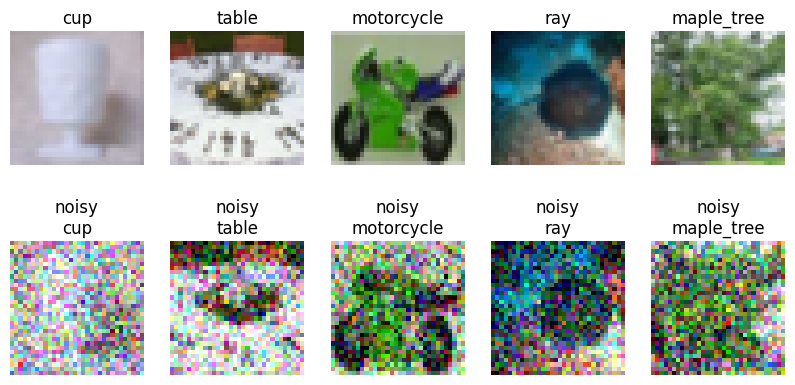

In [ ]:
n_sample = 5
indices = np.random.choice(len(restrainset),n_sample)

plt.figure(figsize = (10,5))
for i in range(n_sample):
    img, label = restrainset[indices[i]]
    img = np.array(img) / 255.
    plt.subplot(2,n_sample,i+1)
    plt.imshow(img)
    plt.title(cifar100_class_names[label])
    plt.axis('off')

    noisy_img = add_noise(img, 0, 0.05)
    plt.subplot(2,n_sample,i+1+n_sample)
    plt.imshow(noisy_img.clip(0,1))
    plt.title(f"noisy\n"+cifar100_class_names[label])
    plt.axis('off')

In [ ]:
cifar_mean=torch.tensor([0.5071, 0.4865, 0.4409]).view(3,1,1)
cifar_std=torch.tensor([0.2673, 0.2564, 0.2762]).view(3,1,1)

cifar_transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((224,224)),
                                 transforms.Normalize(cifar_mean, cifar_std)])

noisy_cifar_transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((224,224)),
                                v2.GaussianNoise(mean = 0.0, sigma = np.sqrt(0.05), clip=True),
                                 transforms.Normalize(cifar_mean, cifar_std)])

# <a id='toc3_'></a>[Resnet](#toc0_)

In [ ]:
def create_resnet18_model(num_classes):
    """
    Create a ResNet18 model with a custom number of output classes.
    
    Uses torchvision's ResNet18 without pretraining for fair comparison.
    
    Args:
        num_classes (int): Number of classes for the output layer.
    
    Returns:
        torch.nn.Module: The modified ResNet18 model.
    """
    resnet18 = torchvision.models.resnet18(pretrained=False)
    # Replace the fully connected layer
    resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, num_classes)
    return resnet18.to(device)

In [ ]:
num_classes = 100
resnet18 = create_resnet18_model(num_classes)
summary(resnet18,input_size = (1,3,224,224))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 100]                  --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

In [ ]:
def get_predictions(model, data_loader, device):
    """
    Get predictions from a model on a dataset.
    
    Args:
        model: The PyTorch model.
        data_loader: DataLoader for the dataset.
        device: Device to run inference on.
    
    Returns:
        tuple: (predictions array, true labels array)
    
    Raises:
        AssertionError: If outputs shape is unexpected.
    """
    y_pred = []
    y_true = []
    model = model.eval().to(device)

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            assert outputs.ndim == 2, f"Expected 2D output, got {outputs.ndim}D"
            assert outputs.shape[0] == images.shape[0], f"Batch size mismatch: outputs {outputs.shape[0]}, images {images.shape[0]}"
            y_pred.append(outputs.argmax(dim=-1).cpu().numpy())

            y_true.append(labels.cpu().numpy())

    # Concatenate all batches
    y_true = np.concatenate(y_true, axis=0).flatten()
    y_pred = np.concatenate(y_pred, axis=0).flatten()
    return y_pred, y_true

In [ ]:
def evaluate(predictions, actual_values, model_names, class_names=None, plot_cm=False):
    """
    Evaluate multiple models using standard classification metrics.
    
    Computes accuracy, precision, recall, and F1-score for each model.
    Optionally plots confusion matrices.
    
    Args:
        predictions: List of prediction arrays.
        actual_values: List of true label arrays.
        model_names: List of model names for indexing.
        class_names: List of class names for confusion matrix labels.
        plot_cm: Whether to plot confusion matrices.
    
    Returns:
        pd.DataFrame: DataFrame with metrics for each model.
    
    Raises:
        AssertionError: If lengths don't match.
    """
    assert len(predictions) == len(actual_values) == len(model_names), "Predictions, actual values, and model names must have the same length."
    scores = defaultdict(lambda: defaultdict(float))
    for i, name in enumerate(model_names):
        # Use macro average for multi-class
        scores[name]["Accuracy"] = accuracy_score(actual_values[i], predictions[i])
        scores[name]["Precision"] = precision_score(actual_values[i], predictions[i], average='weighted', zero_division=0)
        scores[name]["Recall"] = recall_score(actual_values[i], predictions[i], average='weighted', zero_division=0)
        scores[name]["F1 score"] = f1_score(actual_values[i], predictions[i], average='weighted', zero_division=0)
        
        if plot_cm:
            plot_confusion_matrix(actual_values[i], predictions[i], class_names, title=f"Confusion Matrix for {name}")

    return pd.DataFrame(scores)

In [ ]:
def train_epoch(model, data_loader, criterion, optimizer, device):
    """
    Perform one training epoch.
    
    Args:
        model: PyTorch model to train.
        data_loader: DataLoader for training data.
        criterion: Loss function.
        optimizer: Optimizer for updating weights.
        device: Device to run on.
    
    Returns:
        tuple: (average loss, accuracy)
    
    Raises:
        ValueError: If data_loader is empty or model is not on device.
    """
    model.train()
    num_batches = len(data_loader)
    if num_batches == 0:
        raise ValueError("DataLoader is empty.")
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return total_loss / num_batches, correct / total

def validation_epoch(model, data_loader, criterion, device):
    """
    Perform one validation epoch.
    
    Args:
        model: PyTorch model to evaluate.
        data_loader: DataLoader for validation data.
        criterion: Loss function.
        device: Device to run on.
    
    Returns:
        tuple: (average loss, accuracy)
    
    Raises:
        ValueError: If data_loader is empty.
    """
    model.eval()
    total_loss = 0
    num_batches = len(data_loader)
    if num_batches == 0:
        raise ValueError("DataLoader is empty.")
    correct = 0
    total = 0

    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return total_loss / num_batches, correct / total

In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs, device, report_val = True):
  hist = {
      "train_loss": [],
      "train_accuracy": [],
      "val_loss": [],
      "val_accuracy": [],
  }

  model = model.to(device)
  for epoch in range(1, epochs + 1):
    train_loss,train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)
    hist['train_loss'].append(train_loss)
    hist['train_accuracy'].append(train_accuracy)
    print(f"Epoch [{epoch}] Average Training Loss: {train_loss:.4f} Average Training Accuracy: {train_accuracy:.4f}")

    if report_val:
        val_loss,val_accuracy = validation_epoch(model, val_loader, criterion, device)
        hist['val_loss'].append(val_loss)
        hist['val_accuracy'].append(val_accuracy)
        print(f"Epoch [{epoch}] Average Validation Loss: {val_loss:.4f} Average Validation Accuracy: {val_accuracy:.4f}")

  return hist

In [ ]:
def plot_history(history,model_name):
    range_epochs = range(1,len(history['val_loss'])+1)
    plt.plot(range_epochs,history['train_loss'])
    plt.plot(range_epochs,history['val_loss'])
    plt.title(f"{model_name} Model Loss over Epochs")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.ylim(0, max(max(history['train_loss']), max(history['val_loss']))*1.01)
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    plt.plot(range_epochs, history['train_accuracy'])
    plt.plot(range_epochs, history['val_accuracy'])
    plt.title(f"{model_name} Model Accuracy over Epochs")
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend(['Train', 'Val'])
    plt.ylim(0, 1)
    plt.show()

In [ ]:
restrainvalset.set_transform(cifar_transform)
restrainset.set_transform(cifar_transform)
resvalset.set_transform(cifar_transform)
restestset.set_transform(cifar_transform)

In [ ]:
batch_size=64
trainvalloader = DataLoader(restrainvalset, batch_size=batch_size, shuffle=True, num_workers=2)
trainloader = DataLoader(restrainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(resvalset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(restestset, batch_size=batch_size, shuffle=False, num_workers=2)

Epoch [1] Average Training Loss: 4.2870 Average Training Accuracy: 0.0536
Epoch [1] Average Validation Loss: 4.3509 Average Validation Accuracy: 0.0415
Epoch [2] Average Training Loss: 3.9392 Average Training Accuracy: 0.0871
Epoch [2] Average Validation Loss: 3.9592 Average Validation Accuracy: 0.0910
Epoch [3] Average Training Loss: 3.7617 Average Training Accuracy: 0.1081
Epoch [3] Average Validation Loss: 3.9400 Average Validation Accuracy: 0.1090
Epoch [4] Average Training Loss: 3.5928 Average Training Accuracy: 0.1414
Epoch [4] Average Validation Loss: 3.7149 Average Validation Accuracy: 0.1305
Epoch [5] Average Training Loss: 3.4264 Average Training Accuracy: 0.1681
Epoch [5] Average Validation Loss: 3.6235 Average Validation Accuracy: 0.1435
Epoch [6] Average Training Loss: 3.2222 Average Training Accuracy: 0.2032
Epoch [6] Average Validation Loss: 3.4870 Average Validation Accuracy: 0.1675
Epoch [7] Average Training Loss: 3.0404 Average Training Accuracy: 0.2389
Epoch [7] Aver

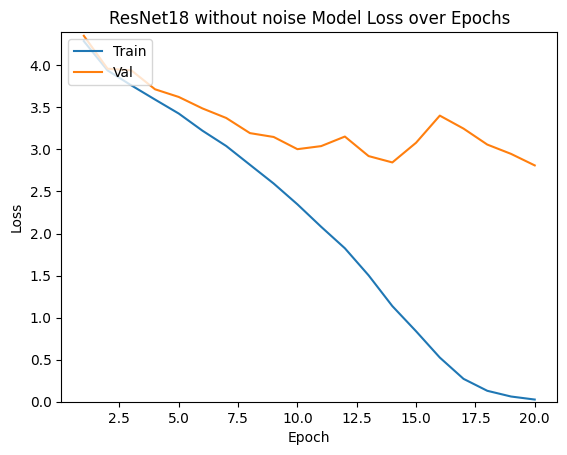

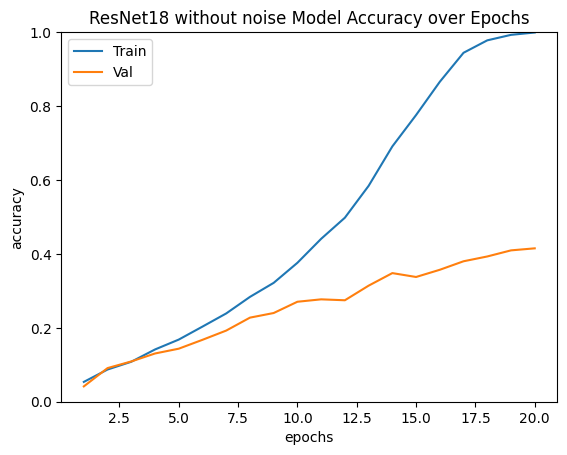

In [ ]:
epochs = 20
lr = 1e-3

resnet18 = create_resnet18_model(num_classes)

optimizer = torch.optim.Adam(resnet18.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

hist = train(resnet18, trainloader, valloader, criterion, optimizer, epochs, device)

state_dict = resnet18.state_dict()
torch.save(state_dict, 'resnet18.pth')

plot_history(hist,'ResNet18 without noise')

In [ ]:
restrainvalset.set_transform(noisy_cifar_transform)
restrainset.set_transform(noisy_cifar_transform)
resvalset.set_transform(noisy_cifar_transform)
restestset.set_transform(noisy_cifar_transform)

Epoch [1] Average Training Loss: 4.2703 Average Training Accuracy: 0.0566
Epoch [1] Average Validation Loss: 4.2726 Average Validation Accuracy: 0.0455
Epoch [2] Average Training Loss: 3.9219 Average Training Accuracy: 0.0902
Epoch [2] Average Validation Loss: 3.8974 Average Validation Accuracy: 0.0910
Epoch [3] Average Training Loss: 3.7113 Average Training Accuracy: 0.1230
Epoch [3] Average Validation Loss: 3.8404 Average Validation Accuracy: 0.1025
Epoch [4] Average Training Loss: 3.5058 Average Training Accuracy: 0.1610
Epoch [4] Average Validation Loss: 3.6016 Average Validation Accuracy: 0.1375
Epoch [5] Average Training Loss: 3.2993 Average Training Accuracy: 0.1955
Epoch [5] Average Validation Loss: 3.4173 Average Validation Accuracy: 0.1790
Epoch [6] Average Training Loss: 3.0804 Average Training Accuracy: 0.2275
Epoch [6] Average Validation Loss: 3.2860 Average Validation Accuracy: 0.2125
Epoch [7] Average Training Loss: 2.8421 Average Training Accuracy: 0.2782
Epoch [7] Aver

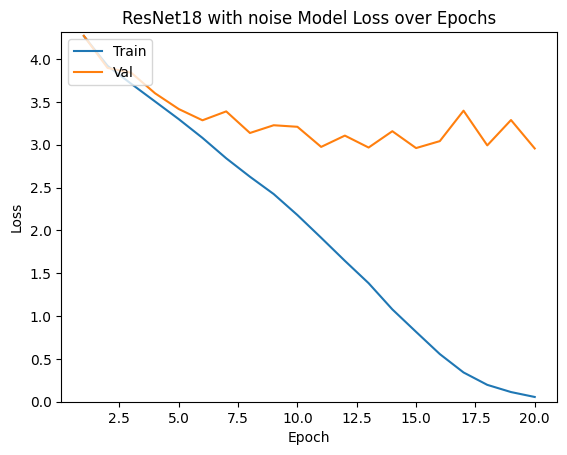

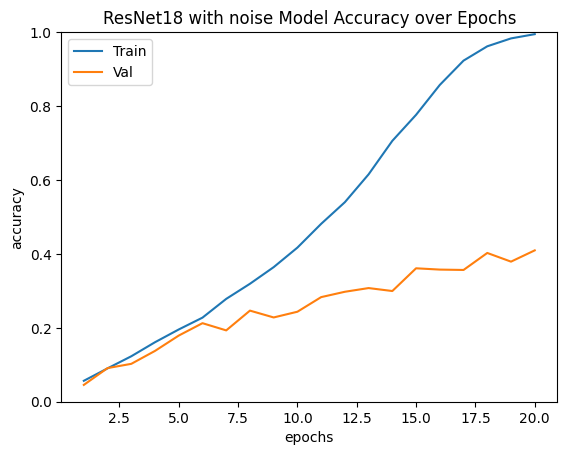

In [ ]:
epochs = 20
lr = 1e-3

noisy_resnet18 = create_resnet18_model(num_classes)

optimizer = torch.optim.Adam(noisy_resnet18.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

hist = train(noisy_resnet18, trainloader, valloader, criterion, optimizer, epochs, device)

state_dict = noisy_resnet18.state_dict()
torch.save(state_dict, 'noisy_resnet18.pth')

plot_history(hist,'ResNet18 with noise')

In [ ]:
restrainvalset.set_transform(cifar_transform)
restrainset.set_transform(cifar_transform)
resvalset.set_transform(cifar_transform)
restestset.set_transform(cifar_transform)

In [ ]:
y_pred = []
y_true = []
model_names = ['ResNet18','Noisy ResNet18']

pred, true = get_predictions(resnet18,valloader,device)
y_pred.append(pred)
y_true.append(true)

pred, true = get_predictions(noisy_resnet18,valloader,device)
y_pred.append(pred)
y_true.append(true)

scores = evaluate(y_pred,y_true,model_names)
scores

ResNet18  Noisy ResNet18
Accuracy   0.415000        0.396000
Precision  0.449881        0.438853
Recall     0.415000        0.396000
F1 score   0.418322        0.397154

# <a id='toc4_'></a>[Prepare Flowers-102 dataset](#toc0_)

In [ ]:
flowers102_class_names = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia?', 'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily', 'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium', 'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen ', 'watercress', 'canna lily', 'hippeastrum ', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily',]

In [ ]:
vittrainset = torchvision.datasets.Flowers102(root='./data', split='train',
                                        download=True)
vitvalset = torchvision.datasets.Flowers102(root='./data', split='val',
                                        download=True)
vittestset = torchvision.datasets.Flowers102(root='./data', split='test',
                                        download=True)

vittrainset = CustomDataset(vittrainset)
vitvalset = CustomDataset(vitvalset)
vittestset = CustomDataset(vittestset)

len(vittrainset),len(vitvalset),len(vittestset)

100%|██████████| 345M/345M [00:20<00:00, 17.0MB/s]
100%|██████████| 502/502 [00:00<00:00, 725kB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 19.8MB/s]


(1020, 1020, 6149)

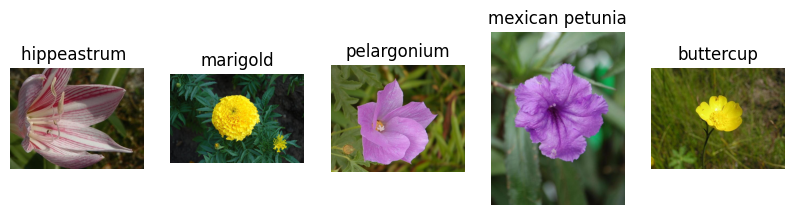

In [ ]:
n_sample = 5
indices = np.random.choice(len(vittrainset),n_sample)

plt.figure(figsize = (10,5))
for i in range(n_sample):
    img, label = vittrainset[indices[i]]
    img = np.array(img) / 255.
    plt.subplot(2,n_sample,i+1)
    plt.imshow(img)
    plt.title(flowers102_class_names[label])
    plt.axis('off')

In [ ]:
mean = (0,0,0)
std = (0,0,0)
for image, _ in vittrainset:
    img = np.array(image) / 255.
    mean += img.mean(axis=(0,1))
    std += img.std(axis=(0,1))

mean /= len(vittrainset)
std /= len(vittrainset)

flowers_mean=torch.tensor(mean,dtype=torch.float32).view(3,1,1)
flowers_std=torch.tensor(std,dtype=torch.float32).view(3,1,1)
print(flowers_mean)
print(flowers_std)

tensor([[[0.4330]],

        [[0.3819]],

        [[0.2964]]])
tensor([[[0.2621]],

        [[0.2133]],

        [[0.2248]]])


Mean = [0.4330, 0.3819, 0.2964]

std = [0.2621, 0.2133, 0.2248]

In [ ]:
flowers_transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((224,224)),
                                 transforms.Normalize(flowers_mean, flowers_std)])

# <a id='toc5_'></a>[ViT](#toc0_)

In [ ]:
def create_vit_model(num_classes,pretrained):
    vit = torchvision.models.vit_b_16(weights="DEFAULT" if pretrained else None)

    if pretrained:
      for param in vit.parameters():
          param.requires_grad = False

    vit.heads.head = nn.Linear(vit.heads.head.in_features, num_classes)
    return vit.to(device)

In [ ]:
num_classes = 102
vit = create_vit_model(num_classes,True)
summary(vit,input_size = (1,3,224,224))

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 176MB/s]


Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 102]                  768
├─Conv2d: 1-1                                 [1, 768, 14, 14]          (590,592)
├─Encoder: 1-2                                [1, 197, 768]             151,296
│    └─Dropout: 2-1                           [1, 197, 768]             --
│    └─Sequential: 2-2                        [1, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-5                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-6                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-

In [ ]:
vittrainset.set_transform(flowers_transform)
vitvalset.set_transform(flowers_transform)
vittestset.set_transform(flowers_transform)

In [ ]:
batch_size=64
trainloader = DataLoader(vittrainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(vitvalset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(vittestset, batch_size=batch_size, shuffle=False, num_workers=2)

Epoch [1] Average Training Loss: 4.2798 Average Training Accuracy: 0.1176
Epoch [1] Average Validation Loss: 3.5705 Average Validation Accuracy: 0.3951
Epoch [2] Average Training Loss: 2.9374 Average Training Accuracy: 0.6510
Epoch [2] Average Validation Loss: 2.7288 Average Validation Accuracy: 0.6157
Epoch [3] Average Training Loss: 2.0474 Average Training Accuracy: 0.8598
Epoch [3] Average Validation Loss: 2.1501 Average Validation Accuracy: 0.7373
Epoch [4] Average Training Loss: 1.4508 Average Training Accuracy: 0.9039
Epoch [4] Average Validation Loss: 1.7757 Average Validation Accuracy: 0.7627
Epoch [5] Average Training Loss: 1.0616 Average Training Accuracy: 0.9451
Epoch [5] Average Validation Loss: 1.5230 Average Validation Accuracy: 0.8049


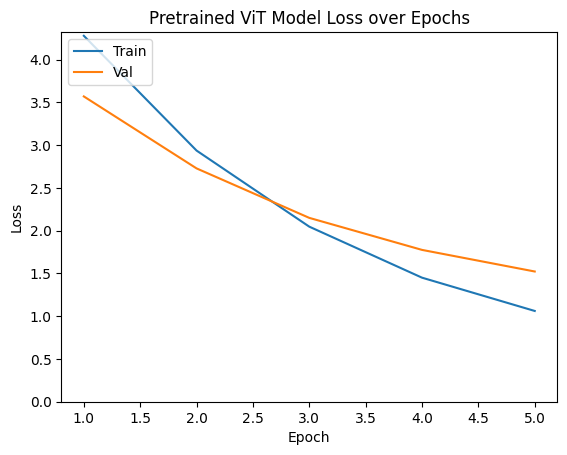

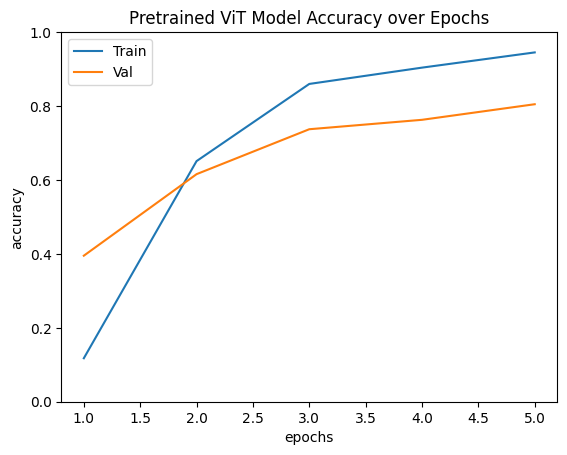

In [ ]:
epochs = 5
lr = 1e-3

pretrained_vit = create_vit_model(num_classes,True)

optimizer = torch.optim.Adam(pretrained_vit.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

hist = train(pretrained_vit, trainloader, valloader, criterion, optimizer, epochs, device)

state_dict = pretrained_vit.state_dict()
torch.save(state_dict, 'pretrained_vit.pth')

plot_history(hist,'Pretrained ViT')

Epoch [1] Average Training Loss: 4.8129 Average Training Accuracy: 0.0147
Epoch [1] Average Validation Loss: 4.3848 Average Validation Accuracy: 0.0412
Epoch [2] Average Training Loss: 4.1122 Average Training Accuracy: 0.0471
Epoch [2] Average Validation Loss: 3.9972 Average Validation Accuracy: 0.0402
Epoch [3] Average Training Loss: 3.8762 Average Training Accuracy: 0.0608
Epoch [3] Average Validation Loss: 3.7478 Average Validation Accuracy: 0.0843
Epoch [4] Average Training Loss: 3.6649 Average Training Accuracy: 0.0892
Epoch [4] Average Validation Loss: 3.6439 Average Validation Accuracy: 0.1039
Epoch [5] Average Training Loss: 3.5148 Average Training Accuracy: 0.0902
Epoch [5] Average Validation Loss: 3.5879 Average Validation Accuracy: 0.1206
Epoch [6] Average Training Loss: 3.4477 Average Training Accuracy: 0.1049
Epoch [6] Average Validation Loss: 3.5464 Average Validation Accuracy: 0.1245
Epoch [7] Average Training Loss: 3.3399 Average Training Accuracy: 0.1284
Epoch [7] Aver

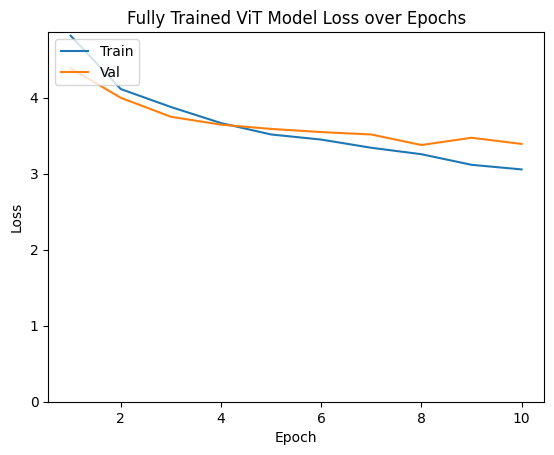

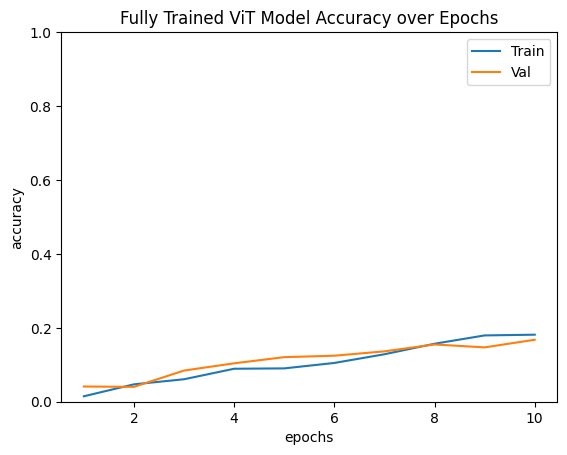

In [ ]:
epochs = 10
lr = 1e-3

vit = create_vit_model(num_classes,False)

optimizer = torch.optim.Adam(vit.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

hist = train(vit, trainloader, valloader, criterion, optimizer, epochs, device)

state_dict = vit.state_dict()
torch.save(state_dict, 'vit.pth')

plot_history(hist,'Fully Trained ViT')

In [ ]:
y_pred = []
y_true = []
model_names = ['Fully Trained ViT','Pretrained ViT']

pred, true = get_predictions(vit,valloader,device)
y_pred.append(pred)
y_true.append(true)

pred, true = get_predictions(pretrained_vit,valloader,device)
y_pred.append(pred)
y_true.append(true)

scores = evaluate(y_pred,y_true,model_names)
scores

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fully Trained ViT  Pretrained ViT
Accuracy            0.167647        0.804902
Precision           0.124071        0.824261
Recall              0.167647        0.804902
F1 score            0.124190        0.798149

In [ ]:
# ! cp 'resnet18.pth' '/content/drive/MyDrive/Colab/NNDL/CAe/Part1/Models/resnet18.pth'
# ! cp 'noisy_resnet18.pth' '/content/drive/MyDrive/Colab/NNDL/CAe/Part1/Models/noisy_resnet18.pth'
# ! cp 'vit.pth' '/content/drive/MyDrive/Colab/NNDL/CAe/Part1/Models/vit.pth'
# ! cp 'pretrained_vit.pth' '/content/drive/MyDrive/Colab/NNDL/CAe/Part1/Models/pretrained_vit.pth'

In [ ]:
! cp 'test_resnet18.pth' '/content/drive/MyDrive/Colab/NNDL/CAe/Part1/Models/'
! cp 'test_noisy_resnet18.pth' '/content/drive/MyDrive/Colab/NNDL/CAe/Part1/Models/'
# ! cp 'test_vit.pth' '/content/drive/MyDrive/Colab/NNDL/CAe/Part1/Models/'
# ! cp 'test_pretrained_vit.pth' '/content/drive/MyDrive/Colab/NNDL/CAe/Part1/Models/'

In [ ]:
# ! cp '/content/drive/MyDrive/Colab/NNDL/CAe/Part1/Models/resnet18.pth' 'resnet18.pth'
# ! cp '/content/drive/MyDrive/Colab/NNDL/CAe/Part1/Models/noisy_resnet18.pth' 'noisy_resnet18.pth'
! cp '/content/drive/MyDrive/Colab/NNDL/CAe/Part1/Models/vit.pth' 'vit.pth'
# ! cp '/content/drive/MyDrive/Colab/NNDL/CAe/Part1/Models/pretrained_vit.pth' 'pretrained_vit.pth'

In [ ]:
# ! cp '/content/drive/MyDrive/Colab/NNDL/CAe/Part1/Models/test_resnet18.pth' 'test_resnet18.pth'
# ! cp '/content/drive/MyDrive/Colab/NNDL/CAe/Part1/Models/test_noisy_resnet18.pth' 'test_noisy_resnet18.pth'
! cp '/content/drive/MyDrive/Colab/NNDL/CAe/Part1/Models/test_vit.pth' 'test_vit.pth'
# ! cp '/content/drive/MyDrive/Colab/NNDL/CAe/Part1/Models/test_pretrained_vit.pth' 'test_pretrained_vit.pth'

# <a id='toc6_'></a>[Implement the Attacks](#toc0_)

In [ ]:
class AdversarialDataLoader(DataLoader):
    def __init__(self, *args, attack, attack_args, mean, std, device, **kwargs):
        super().__init__(*args, **kwargs)
        self.attack = attack
        self.attack_args = attack_args
        self.device = device
        self.attack_mode = False
        self.clean_mode = False

        self.mean = mean.to(device)
        self.std = std.to(device)

    def __iter__(self):
        data_iter = super().__iter__()
        for images, labels in data_iter:
            images, labels = images.to(self.device), labels.to(self.device)

            if self.attack_mode and not self.clean_mode:
                adv_images = self.attack(images, labels, self.mean, self.std, self.attack_args)
                yield adv_images, labels
            elif self.attack_mode:
                adv_images = self.attack(images, labels, self.mean, self.std, self.attack_args)
                yield images, adv_images, labels
            else:
                yield images, labels

    def set_attack_mode(self):
        self.attack_mode = True
        self.clean_mode = False

    def set_clean_mode(self):
        self.attack_mode = False
        self.clean_mode = True

    def set_both_mode(self):
        self.attack_mode = True
        self.clean_mode = True

# <a id='toc7_'></a>[Adversarial Training](#toc0_)

In [ ]:
def plot_adversarial_example(loader, model,class_names,mean,std, device):
    model.eval()
    loader.set_both_mode()
    dataiter = iter(loader)
    plt.figure(figsize = (12,8))

    while True:
        images, adv_images, labels = next(dataiter)
        image = images[0]
        adv_image = adv_images[0]
        label = labels[0]
        std = std.to(device)
        mean = mean.to(device)

        unscaled_img = image * std + mean
        unscaled_img = unscaled_img.cpu().numpy().clip(0,1)

        with torch.no_grad():
            logits = model(image.unsqueeze(0))
            probs = logits.softmax(dim=-1)
            preds = probs.argmax(dim=-1).cpu().numpy()

        image = image.unsqueeze(0).to(device)
        label = label.unsqueeze(0).to(device)

        unscaled_adv_image = adv_image * std + mean
        unscaled_adv_image = unscaled_adv_image.cpu().numpy().clip(0,1)

        noise = np.abs(unscaled_adv_image-unscaled_img)

        with torch.no_grad():
            logits = model(adv_image.unsqueeze(0))
            adv_probs = logits.softmax(dim=-1)
            adv_preds = adv_probs.argmax(dim=-1).cpu().numpy()

        if preds[0] != adv_preds[0]:
            break

    plt.subplot(1,3,1)
    plt.imshow(np.transpose(unscaled_img, (1, 2, 0)))
    plt.title(f"clean image with label: {class_names[label]}\nclassified as: {class_names[preds[0]]}\nconfidence:{probs[0,preds[0]].item():.2f}")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(np.transpose(noise, (1, 2, 0)))
    plt.title(f"added noise\nmax value = {noise.max():.2f}")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(np.transpose(unscaled_adv_image, (1, 2, 0)))
    plt.title(f"adversarial example image classified as: {class_names[adv_preds[0]]}\nconfidence:{adv_probs[0,adv_preds[0]].item():.2f}")
    plt.axis('off')

## <a id='toc7_1_'></a>[FGSM](#toc0_)

In [ ]:
def fgsm_attack(images, labels, mean, std, args):
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    images.requires_grad = True

    model = args['model']
    epsilon = args['epsilon']

    outputs = model(images)
    loss = nn.CrossEntropyLoss()(outputs, labels)
    model.zero_grad()
    loss.backward()

    perturbation = epsilon * images.grad.sign()
    images = images * std + mean
    adv_images = images + perturbation
    adv_images = torch.clamp(adv_images, 0, 1).detach()
    adv_images = (adv_images - mean) / std

    return adv_images

### <a id='toc7_1_1_'></a>[ResNet](#toc0_)

In [ ]:
attack = fgsm_attack
attack_args = {'epsilon': 0.1,
              'alpha': 0.02,
              'steps': 7,}

In [ ]:
restrainvalset.set_transform(cifar_transform)
restrainset.set_transform(cifar_transform)
resvalset.set_transform(cifar_transform)
restestset.set_transform(cifar_transform)

In [ ]:
batch_size=64
trainvalloader = AdversarialDataLoader(restrainvalset, batch_size=batch_size, shuffle=True, num_workers=2,
                                   attack=attack,mean=cifar_mean,std=cifar_std,device=device,attack_args=attack_args)
trainloader = AdversarialDataLoader(restrainset, batch_size=batch_size, shuffle=True, num_workers=2,
                                   attack=attack,mean=cifar_mean,std=cifar_std,device=device,attack_args=attack_args)
valloader = AdversarialDataLoader(resvalset, batch_size=batch_size, shuffle=False, num_workers=2,
                                 attack=attack,mean=cifar_mean,std=cifar_std,device=device,attack_args=attack_args)
testloader = AdversarialDataLoader(restestset, batch_size=batch_size, shuffle=False, num_workers=2,
                                  attack=attack,mean=cifar_mean,std=cifar_std,device=device,attack_args=attack_args)

In [ ]:
resnet18 = create_resnet18_model(100)
noisy_resnet18 = create_resnet18_model(100)

try:
    resnet18.load_state_dict(torch.load('resnet18.pth'))
    print("Successfully loaded ResNet18 model.")
except FileNotFoundError:
    print("Error: 'resnet18.pth' not found. Please train the model first.")
    raise
except Exception as e:
    print(f"Error loading ResNet18 model: {e}")
    raise

try:
    noisy_resnet18.load_state_dict(torch.load('noisy_resnet18.pth'))
    print("Successfully loaded noisy ResNet18 model.")
except FileNotFoundError:
    print("Error: 'noisy_resnet18.pth' not found. Please train the model first.")
    raise
except Exception as e:
    print(f"Error loading noisy ResNet18 model: {e}")
    raise

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

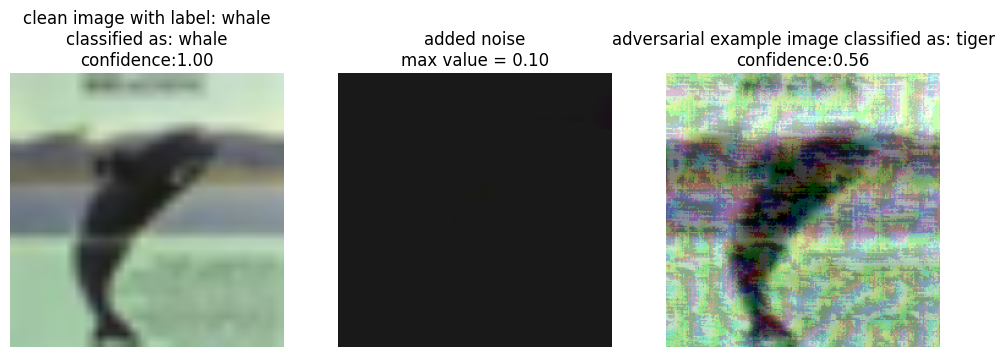

In [ ]:
attack_args['model'] = resnet18
plot_adversarial_example(valloader, resnet18,cifar100_class_names,cifar_mean,cifar_std, device)

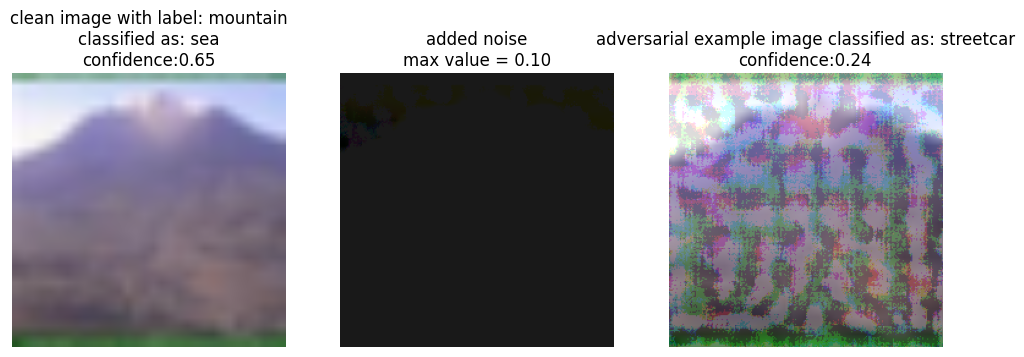

In [ ]:
attack_args['model'] = noisy_resnet18
plot_adversarial_example(valloader, noisy_resnet18,cifar100_class_names,cifar_mean,cifar_std, device)

In [ ]:
trainvalloader.set_attack_mode()
trainloader.set_attack_mode()
valloader.set_attack_mode()
testloader.set_attack_mode()

In [ ]:
y_pred = []
y_true = []
model_names = ['ResNet18 FGSM attacked','Noisy ResNet18 FGSM attacked']

attack_args['model'] = resnet18
pred, true = get_predictions(resnet18,valloader,device)
y_pred.append(pred)
y_true.append(true)

attack_args['model'] = noisy_resnet18
pred, true = get_predictions(noisy_resnet18,valloader,device)
y_pred.append(pred)
y_true.append(true)

scores = evaluate(y_pred,y_true,model_names, class_names=cifar100_class_names)
scores

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

ResNet18 FGSM attacked  Noisy ResNet18 FGSM attacked
Accuracy                      0.0                           0.0
Precision                     0.0                           0.0
Recall                        0.0                           0.0
F1 score                      0.0                           0.0

Epoch [1] Average Training Loss: 5.6665 Average Training Accuracy: 0.0375
Epoch [1] Average Validation Loss: 4.4856 Average Validation Accuracy: 0.0375
Epoch [2] Average Training Loss: 4.2154 Average Training Accuracy: 0.0615
Epoch [2] Average Validation Loss: 4.5858 Average Validation Accuracy: 0.0560
Epoch [3] Average Training Loss: 3.7233 Average Training Accuracy: 0.1269
Epoch [3] Average Validation Loss: 3.8995 Average Validation Accuracy: 0.1105
Epoch [4] Average Training Loss: 2.6849 Average Training Accuracy: 0.3038
Epoch [4] Average Validation Loss: 3.7374 Average Validation Accuracy: 0.2090
Epoch [5] Average Training Loss: 1.4234 Average Training Accuracy: 0.6082
Epoch [5] Average Validation Loss: 2.6924 Average Validation Accuracy: 0.3645
Epoch [6] Average Training Loss: 0.6381 Average Training Accuracy: 0.8350
Epoch [6] Average Validation Loss: 1.9596 Average Validation Accuracy: 0.5130
Epoch [7] Average Training Loss: 0.1773 Average Training Accuracy: 0.9694
Epoch [7] Aver

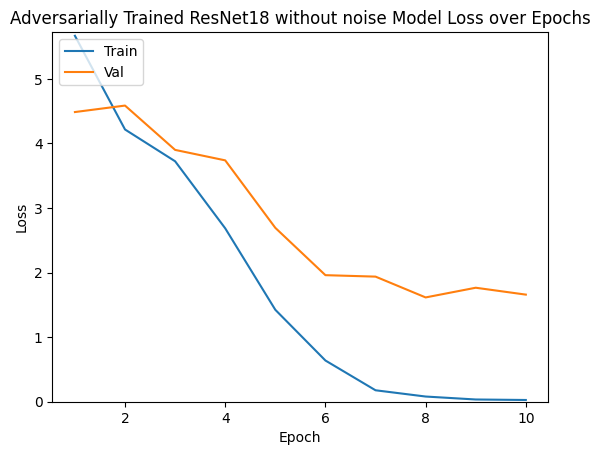

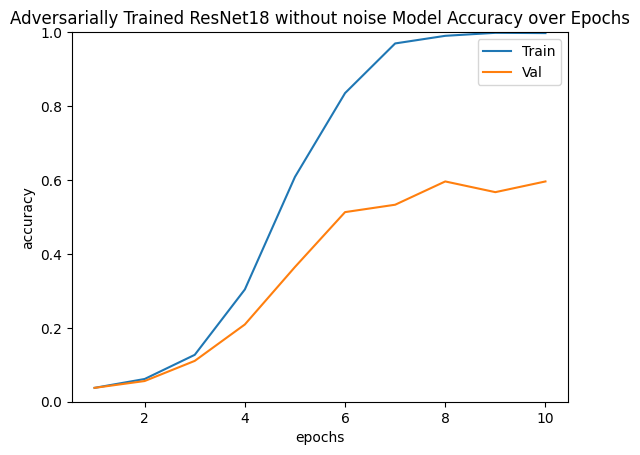

In [ ]:
epochs = 10
lr = 1e-3

attack_args['model'] = resnet18
optimizer = torch.optim.Adam(resnet18.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

hist = train(resnet18, trainloader, valloader, criterion, optimizer, epochs, device)

plot_history(hist,'Adversarially Trained ResNet18 without noise')

Epoch [1] Average Training Loss: 5.6882 Average Training Accuracy: 0.0366
Epoch [1] Average Validation Loss: 4.6729 Average Validation Accuracy: 0.0230
Epoch [2] Average Training Loss: 4.4869 Average Training Accuracy: 0.0349
Epoch [2] Average Validation Loss: 4.5884 Average Validation Accuracy: 0.0330
Epoch [3] Average Training Loss: 4.4279 Average Training Accuracy: 0.0391
Epoch [3] Average Validation Loss: 4.5603 Average Validation Accuracy: 0.0335
Epoch [4] Average Training Loss: 4.3754 Average Training Accuracy: 0.0476
Epoch [4] Average Validation Loss: 4.5435 Average Validation Accuracy: 0.0425
Epoch [5] Average Training Loss: 4.3375 Average Training Accuracy: 0.0476
Epoch [5] Average Validation Loss: 4.7512 Average Validation Accuracy: 0.0330
Epoch [6] Average Training Loss: 4.1170 Average Training Accuracy: 0.0793
Epoch [6] Average Validation Loss: 4.0925 Average Validation Accuracy: 0.0915
Epoch [7] Average Training Loss: 3.2767 Average Training Accuracy: 0.2104
Epoch [7] Aver

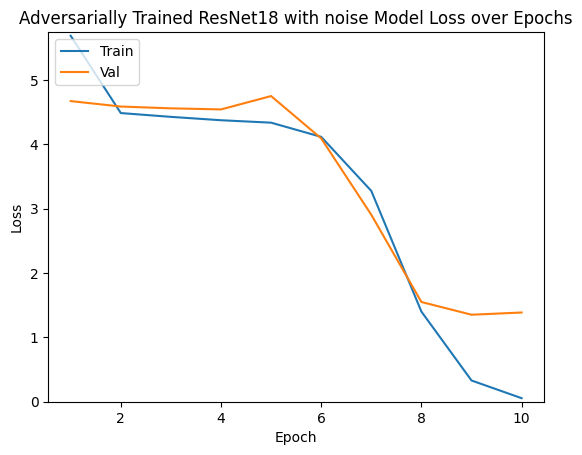

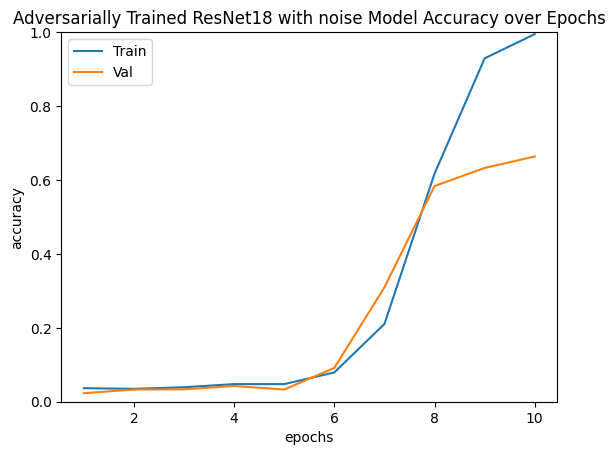

In [ ]:
epochs = 10
lr = 1e-3

attack_args['model'] = noisy_resnet18
optimizer = torch.optim.Adam(noisy_resnet18.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

hist = train(noisy_resnet18, trainloader, valloader, criterion, optimizer, epochs, device)

plot_history(hist,'Adversarially Trained ResNet18 with noise')

In [ ]:
y_pred = []
y_true = []
model_names = ['ResNet18 FGSM attacked','Noisy ResNet18 FGSM attacked', 'ResNet18 clean','Noisy ResNet18 clean']

attack_args['model'] = resnet18
pred, true = get_predictions(resnet18,valloader,device)
y_pred.append(pred)
y_true.append(true)

attack_args['model'] = noisy_resnet18
pred, true = get_predictions(noisy_resnet18,valloader,device)
y_pred.append(pred)
y_true.append(true)

trainvalloader.set_clean_mode()
trainloader.set_clean_mode()
valloader.set_clean_mode()
testloader.set_clean_mode()

pred, true = get_predictions(resnet18,valloader,device)
y_pred.append(pred)
y_true.append(true)

pred, true = get_predictions(noisy_resnet18,valloader,device)
y_pred.append(pred)
y_true.append(true)

scores = evaluate(y_pred,y_true,model_names, class_names=cifar100_class_names)
scores

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

ResNet18 FGSM attacked  Noisy ResNet18 FGSM attacked  \
Accuracy                 0.596000                      0.663500   
Precision                0.658047                      0.710513   
Recall                   0.596000                      0.663500   
F1 score                 0.600279                      0.666739   

           ResNet18 clean  Noisy ResNet18 clean  
Accuracy         0.282000              0.284000  
Precision        0.396282              0.362982  
Recall           0.282000              0.284000  
F1 score         0.284951              0.275497

### <a id='toc7_1_2_'></a>[ViT](#toc0_)

In [ ]:
trainloader = AdversarialDataLoader(vittrainset, batch_size=batch_size, shuffle=True, num_workers=2,
                                  attack=attack,mean=flowers_mean,std=flowers_std,device=device,attack_args=attack_args)
valloader = AdversarialDataLoader(vitvalset, batch_size=batch_size, shuffle=False, num_workers=2,
                                  attack=attack,mean=flowers_mean,std=flowers_std,device=device,attack_args=attack_args)
testloader = AdversarialDataLoader(vittestset, batch_size=batch_size, shuffle=False, num_workers=2,
                                  attack=attack,mean=flowers_mean,std=flowers_std,device=device,attack_args=attack_args)

In [ ]:
vittrainset.set_transform(flowers_transform)
vitvalset.set_transform(flowers_transform)
vittestset.set_transform(flowers_transform)

In [ ]:
vit = create_vit_model(102,False)
pretrained_vit = create_vit_model(102,True)

vit.load_state_dict(torch.load('vit.pth'))
pretrained_vit.load_state_dict(torch.load('pretrained_vit.pth'))

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:06<00:00, 55.7MB/s]


<All keys matched successfully>

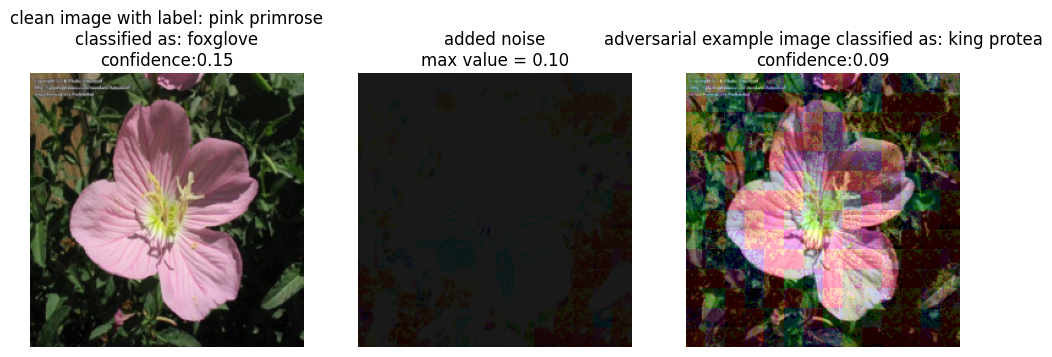

In [ ]:
attack_args['model'] = vit
plot_adversarial_example(valloader, vit,flowers102_class_names,flowers_mean,flowers_std, device)

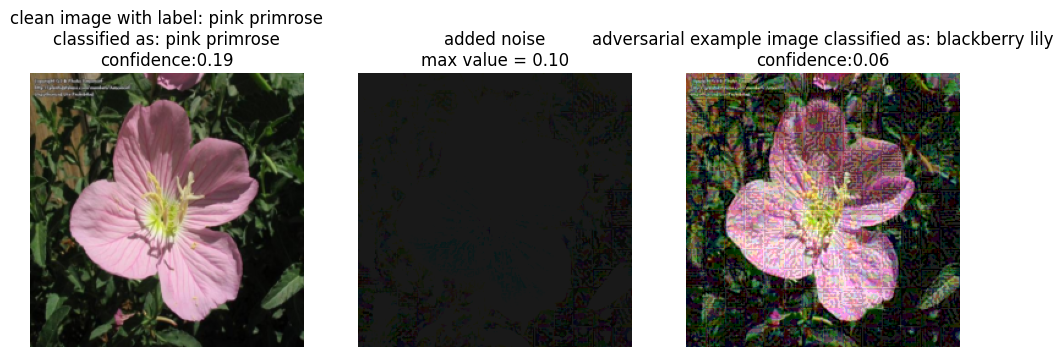

In [ ]:
attack_args['model'] = pretrained_vit
plot_adversarial_example(valloader, pretrained_vit,flowers102_class_names,flowers_mean,flowers_std, device)

In [ ]:
trainloader.set_attack_mode()
valloader.set_attack_mode()
testloader.set_attack_mode()

In [ ]:
y_pred = []
y_true = []
model_names = ['Fully Trained ViT FGSM attacked','Pretrained ViT FGSM attacked']

attack_args['model'] = vit
pred, true = get_predictions(vit,valloader,device)
y_pred.append(pred)
y_true.append(true)

attack_args['model'] = pretrained_vit
pred, true = get_predictions(pretrained_vit,valloader,device)
y_pred.append(pred)
y_true.append(true)

scores = evaluate(y_pred,y_true,model_names, class_names=flowers102_class_names)
scores

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Fully Trained ViT FGSM attacked  Pretrained ViT FGSM attacked
Accuracy                          0.025490                      0.017647
Precision                         0.021775                      0.021017
Recall                            0.025490                      0.017647
F1 score                          0.013235                      0.012069

Epoch [1] Average Training Loss: 4.6510 Average Training Accuracy: 0.0255
Epoch [1] Average Validation Loss: 4.2947 Average Validation Accuracy: 0.0422
Epoch [2] Average Training Loss: 4.1854 Average Training Accuracy: 0.0461
Epoch [2] Average Validation Loss: 4.0950 Average Validation Accuracy: 0.0412
Epoch [3] Average Training Loss: 3.9783 Average Training Accuracy: 0.0480
Epoch [3] Average Validation Loss: 3.9665 Average Validation Accuracy: 0.0627
Epoch [4] Average Training Loss: 3.9420 Average Training Accuracy: 0.0520
Epoch [4] Average Validation Loss: 4.1153 Average Validation Accuracy: 0.0422
Epoch [5] Average Training Loss: 3.9210 Average Training Accuracy: 0.0422
Epoch [5] Average Validation Loss: 3.9182 Average Validation Accuracy: 0.0686
Epoch [6] Average Training Loss: 3.7836 Average Training Accuracy: 0.0706
Epoch [6] Average Validation Loss: 3.9663 Average Validation Accuracy: 0.0735
Epoch [7] Average Training Loss: 3.7805 Average Training Accuracy: 0.0765
Epoch [7] Aver

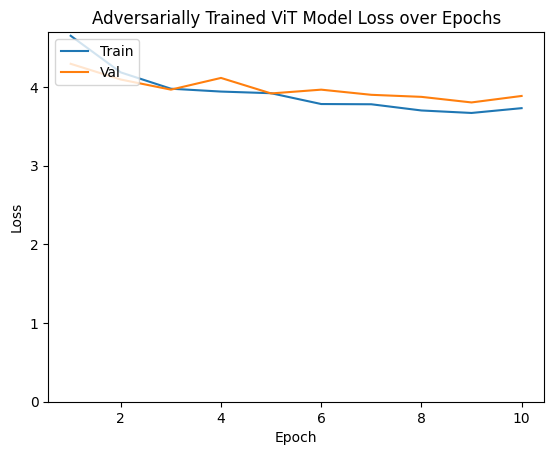

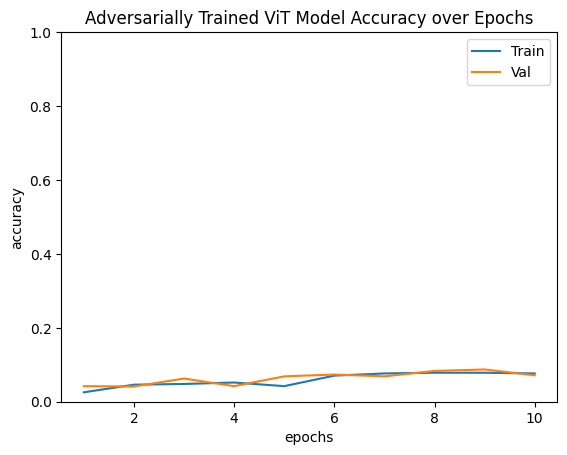

In [ ]:
epochs = 10
lr = 1e-3

attack_args['model'] = vit
optimizer = torch.optim.Adam(vit.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

hist = train(vit, trainloader, valloader, criterion, optimizer, epochs, device)

plot_history(hist,'Adversarially Trained ViT')

Epoch [1] Average Training Loss: 4.5958 Average Training Accuracy: 0.0382
Epoch [1] Average Validation Loss: 4.5696 Average Validation Accuracy: 0.0490
Epoch [2] Average Training Loss: 3.8679 Average Training Accuracy: 0.1216
Epoch [2] Average Validation Loss: 4.3341 Average Validation Accuracy: 0.0627
Epoch [3] Average Training Loss: 3.4413 Average Training Accuracy: 0.2176
Epoch [3] Average Validation Loss: 4.1749 Average Validation Accuracy: 0.0892
Epoch [4] Average Training Loss: 3.1286 Average Training Accuracy: 0.3000
Epoch [4] Average Validation Loss: 4.0718 Average Validation Accuracy: 0.1059
Epoch [5] Average Training Loss: 2.8991 Average Training Accuracy: 0.3765
Epoch [5] Average Validation Loss: 4.0111 Average Validation Accuracy: 0.1186
Epoch [6] Average Training Loss: 2.7140 Average Training Accuracy: 0.4235
Epoch [6] Average Validation Loss: 3.9916 Average Validation Accuracy: 0.1235
Epoch [7] Average Training Loss: 2.5203 Average Training Accuracy: 0.4990
Epoch [7] Aver

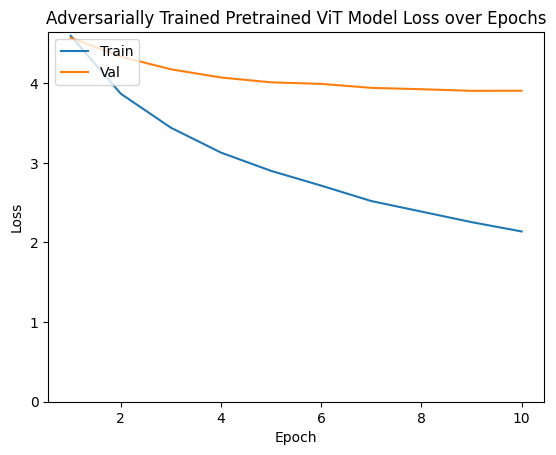

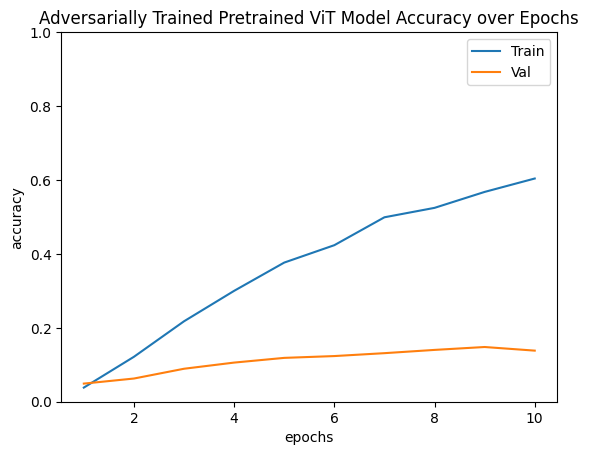

In [ ]:
epochs = 10
lr = 1e-3

attack_args['model'] = pretrained_vit
optimizer = torch.optim.Adam(pretrained_vit.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

hist = train(pretrained_vit, trainloader, valloader, criterion, optimizer, epochs, device)

plot_history(hist,'Adversarially Trained Pretrained ViT')

In [ ]:
y_pred = []
y_true = []
model_names = ['ViT FGSM attacked','Pretrained ViT FGSM attacked', 'ViT clean','Pretrained ViT clean']

attack_args['model'] = vit
pred, true = get_predictions(vit,valloader,device)
y_pred.append(pred)
y_true.append(true)

attack_args['model'] = pretrained_vit
pred, true = get_predictions(pretrained_vit,valloader,device)
y_pred.append(pred)
y_true.append(true)

trainvalloader.set_clean_mode()
trainloader.set_clean_mode()
valloader.set_clean_mode()
testloader.set_clean_mode()

pred, true = get_predictions(vit,valloader,device)
y_pred.append(pred)
y_true.append(true)

pred, true = get_predictions(pretrained_vit,valloader,device)
y_pred.append(pred)
y_true.append(true)

scores = evaluate(y_pred,y_true,model_names, class_names=flowers102_class_names)
scores

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

ViT FGSM attacked  Pretrained ViT FGSM attacked  ViT clean  \
Accuracy            0.071569                      0.138235   0.101961   
Precision           0.054928                      0.120116   0.064799   
Recall              0.071569                      0.138235   0.101961   
F1 score            0.046932                      0.117379   0.063218   

           Pretrained ViT clean  
Accuracy               0.665686  
Precision              0.770396  
Recall                 0.665686  
F1 score               0.645172

## <a id='toc7_2_'></a>[PGD](#toc0_)

In [ ]:
def pgd_attack(images, labels, mean, std, args):
    original_images = images.clone().detach().to(device)
    original_images = original_images * std + mean
    labels = labels.to(device)
    adv_images = original_images.clone().detach()

    model = args['model'].eval()
    alpha = args['alpha']
    epsilon = args['epsilon']
    steps = args['steps']
    criterion = nn.CrossEntropyLoss()

    for i in range(steps):
        adv_images.requires_grad = True
        outputs = model(adv_images)
        loss = criterion(outputs, labels)
        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            adv_images = adv_images + alpha * adv_images.grad.sign()
            delta = torch.clamp(adv_images - original_images, -epsilon, epsilon)
            adv_images = torch.clamp(original_images + delta, 0, 1)

        adv_images = adv_images.detach()

    adv_images = (adv_images - mean) / std
    return adv_images

### <a id='toc7_2_1_'></a>[ResNet](#toc0_)

In [ ]:
attack = pgd_attack

In [ ]:
trainvalloader = AdversarialDataLoader(restrainvalset, batch_size=batch_size, shuffle=True, num_workers=2,
                                   attack=attack,mean=cifar_mean,std=cifar_std,device=device,attack_args=attack_args)
trainloader = AdversarialDataLoader(restrainset, batch_size=batch_size, shuffle=True, num_workers=2,
                                   attack=attack,mean=cifar_mean,std=cifar_std,device=device,attack_args=attack_args)
valloader = AdversarialDataLoader(resvalset, batch_size=batch_size, shuffle=False, num_workers=2,
                                 attack=attack,mean=cifar_mean,std=cifar_std,device=device,attack_args=attack_args)
testloader = AdversarialDataLoader(restestset, batch_size=batch_size, shuffle=False, num_workers=2,
                                  attack=attack,mean=cifar_mean,std=cifar_std,device=device,attack_args=attack_args)

In [ ]:
restrainvalset.set_transform(cifar_transform)
restrainset.set_transform(cifar_transform)
resvalset.set_transform(cifar_transform)
restestset.set_transform(cifar_transform)

resnet18 = create_resnet18_model(100)
noisy_resnet18 = create_resnet18_model(100)

resnet18.load_state_dict(torch.load('resnet18.pth'))
noisy_resnet18.load_state_dict(torch.load('noisy_resnet18.pth'))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

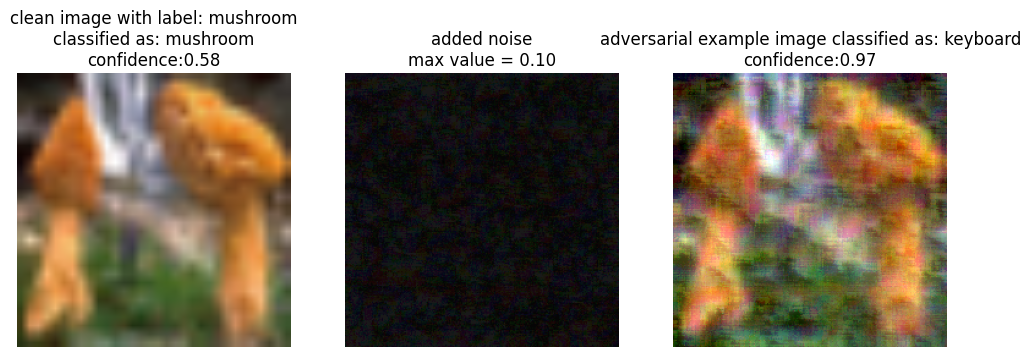

In [ ]:
attack_args['model'] = resnet18
plot_adversarial_example(valloader, resnet18,cifar100_class_names,cifar_mean,cifar_std, device)

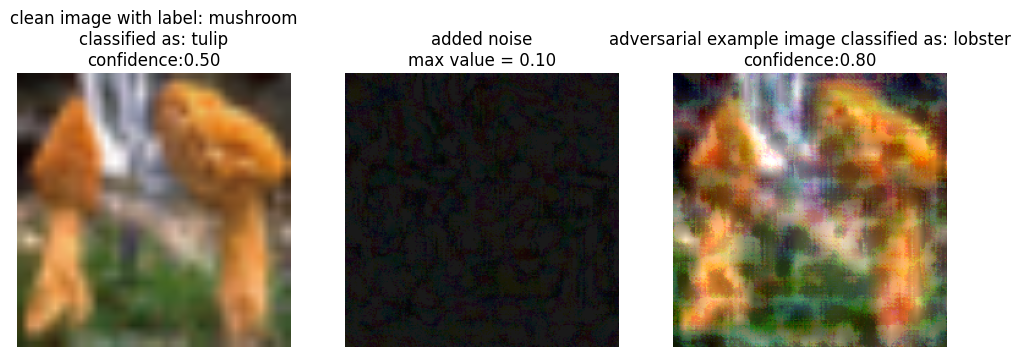

In [ ]:
attack_args['model'] = noisy_resnet18
plot_adversarial_example(valloader, noisy_resnet18,cifar100_class_names,cifar_mean,cifar_std, device)

In [ ]:
trainvalloader.set_attack_mode()
trainloader.set_attack_mode()
valloader.set_attack_mode()
testloader.set_attack_mode()

In [ ]:
y_pred = []
y_true = []
model_names = ['ResNet18 PGD attacked','Noisy ResNet18 PGD attacked']

attack_args['model'] = resnet18
pred, true = get_predictions(resnet18,valloader,device)
y_pred.append(pred)
y_true.append(true)

attack_args['model'] = noisy_resnet18
pred, true = get_predictions(noisy_resnet18,valloader,device)
y_pred.append(pred)
y_true.append(true)

scores = evaluate(y_pred,y_true,model_names, class_names=cifar100_class_names)
scores

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

ResNet18 PGD attacked  Noisy ResNet18 PGD attacked
Accuracy                0.002500                     0.006000
Precision               0.006243                     0.020830
Recall                  0.002500                     0.006000
F1 score                0.003218                     0.005522

Epoch [1] Average Training Loss: 6.9442 Average Training Accuracy: 0.0158
Epoch [1] Average Validation Loss: 4.6637 Average Validation Accuracy: 0.0315
Epoch [2] Average Training Loss: 4.6031 Average Training Accuracy: 0.0264
Epoch [2] Average Validation Loss: 4.5663 Average Validation Accuracy: 0.0415
Epoch [3] Average Training Loss: 4.5411 Average Training Accuracy: 0.0302
Epoch [3] Average Validation Loss: 4.4537 Average Validation Accuracy: 0.0555
Epoch [4] Average Training Loss: 4.5025 Average Training Accuracy: 0.0340
Epoch [4] Average Validation Loss: 4.4683 Average Validation Accuracy: 0.0515
Epoch [5] Average Training Loss: 4.4812 Average Training Accuracy: 0.0350
Epoch [5] Average Validation Loss: 4.4277 Average Validation Accuracy: 0.0555
Epoch [6] Average Training Loss: 4.4468 Average Training Accuracy: 0.0364
Epoch [6] Average Validation Loss: 4.4707 Average Validation Accuracy: 0.0440
Epoch [7] Average Training Loss: 4.4275 Average Training Accuracy: 0.0451
Epoch [7] Aver

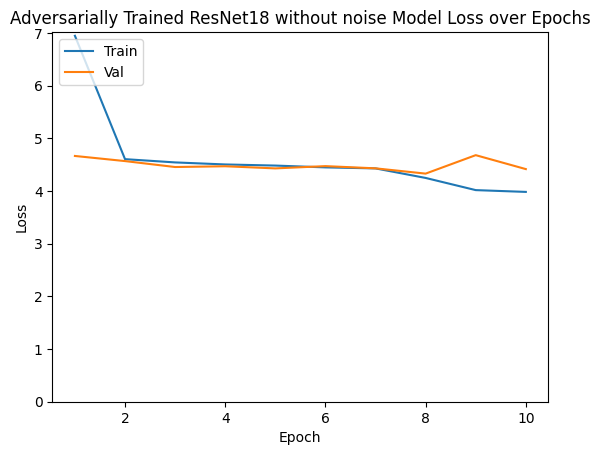

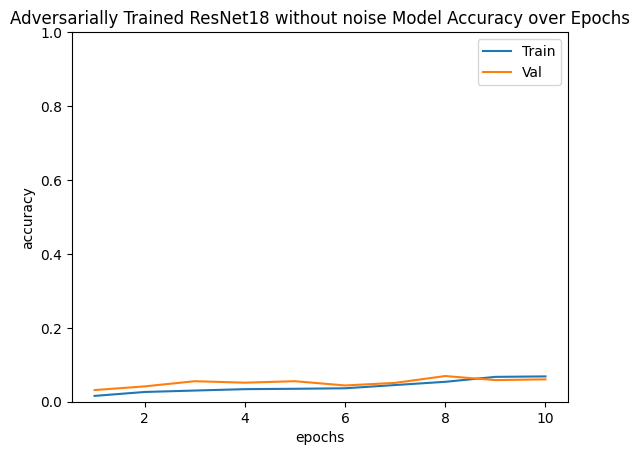

In [ ]:
epochs = 10
lr = 1e-3

attack_args['model'] = resnet18
optimizer = torch.optim.Adam(resnet18.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

hist = train(resnet18, trainloader, valloader, criterion, optimizer, epochs, device)

plot_history(hist,'Adversarially Trained ResNet18 without noise')

Epoch [1] Average Training Loss: 6.8683 Average Training Accuracy: 0.0164
Epoch [1] Average Validation Loss: 4.6032 Average Validation Accuracy: 0.0415
Epoch [2] Average Training Loss: 4.6012 Average Training Accuracy: 0.0284
Epoch [2] Average Validation Loss: 4.5726 Average Validation Accuracy: 0.0370
Epoch [3] Average Training Loss: 4.5358 Average Training Accuracy: 0.0314
Epoch [3] Average Validation Loss: 4.5053 Average Validation Accuracy: 0.0410
Epoch [4] Average Training Loss: 4.4952 Average Training Accuracy: 0.0349
Epoch [4] Average Validation Loss: 4.4938 Average Validation Accuracy: 0.0440
Epoch [5] Average Training Loss: 4.4667 Average Training Accuracy: 0.0385
Epoch [5] Average Validation Loss: 4.4453 Average Validation Accuracy: 0.0570
Epoch [6] Average Training Loss: 4.4449 Average Training Accuracy: 0.0367
Epoch [6] Average Validation Loss: 4.4318 Average Validation Accuracy: 0.0590
Epoch [7] Average Training Loss: 4.4240 Average Training Accuracy: 0.0435
Epoch [7] Aver

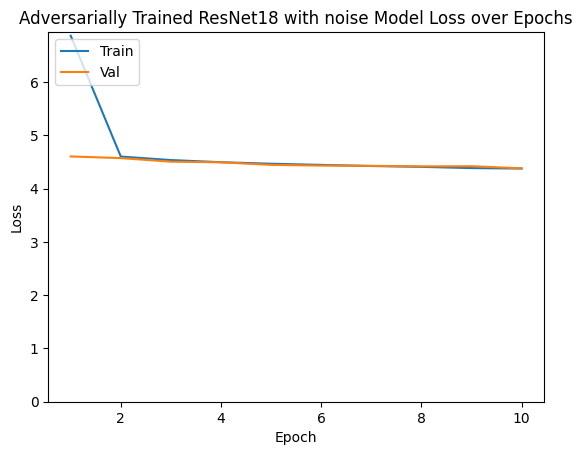

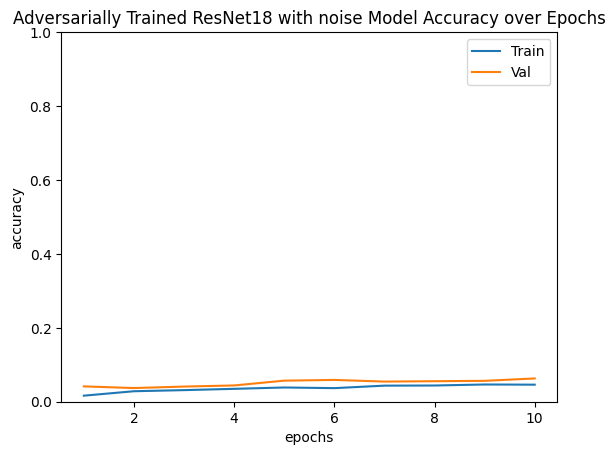

In [ ]:
epochs = 10
lr = 1e-3

attack_args['model'] = noisy_resnet18
optimizer = torch.optim.Adam(noisy_resnet18.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

hist = train(noisy_resnet18, trainloader, valloader, criterion, optimizer, epochs, device)

plot_history(hist,'Adversarially Trained ResNet18 with noise')

In [ ]:
y_pred = []
y_true = []
model_names = ['ResNet18 PGD attacked','Noisy ResNet18 PGD attacked', 'ResNet18 clean','Noisy ResNet18 clean']

attack_args['model'] = resnet18
pred, true = get_predictions(resnet18,valloader,device)
y_pred.append(pred)
y_true.append(true)

attack_args['model'] = noisy_resnet18
pred, true = get_predictions(noisy_resnet18,valloader,device)
y_pred.append(pred)
y_true.append(true)

trainvalloader.set_clean_mode()
trainloader.set_clean_mode()
valloader.set_clean_mode()
testloader.set_clean_mode()

pred, true = get_predictions(resnet18,valloader,device)
y_pred.append(pred)
y_true.append(true)

pred, true = get_predictions(noisy_resnet18,valloader,device)
y_pred.append(pred)
y_true.append(true)

scores = evaluate(y_pred,y_true,model_names, class_names=cifar100_class_names)
scores

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

ResNet18 PGD attacked  Noisy ResNet18 PGD attacked  ResNet18 clean  \
Accuracy                0.060500                     0.063000        0.097000   
Precision               0.050047                     0.048642        0.115367   
Recall                  0.060500                     0.063000        0.097000   
F1 score                0.039994                     0.037913        0.067785   

           Noisy ResNet18 clean  
Accuracy               0.097500  
Precision              0.103789  
Recall                 0.097500  
F1 score               0.062774

### <a id='toc7_2_2_'></a>[ViT](#toc0_)

In [ ]:
trainloader = AdversarialDataLoader(vittrainset, batch_size=batch_size, shuffle=True, num_workers=2,
                                  attack=attack,mean=flowers_mean,std=flowers_std,device=device,attack_args=attack_args)
valloader = AdversarialDataLoader(vitvalset, batch_size=batch_size, shuffle=False, num_workers=2,
                                  attack=attack,mean=flowers_mean,std=flowers_std,device=device,attack_args=attack_args)
testloader = AdversarialDataLoader(vittestset, batch_size=batch_size, shuffle=False, num_workers=2,
                                  attack=attack,mean=flowers_mean,std=flowers_std,device=device,attack_args=attack_args)

In [ ]:
vittrainset.set_transform(flowers_transform)
vitvalset.set_transform(flowers_transform)
vittestset.set_transform(flowers_transform)

vit = create_vit_model(102,False)
pretrained_vit = create_vit_model(102,True)

vit.load_state_dict(torch.load('vit.pth'))
pretrained_vit.load_state_dict(torch.load('pretrained_vit.pth'))

<All keys matched successfully>

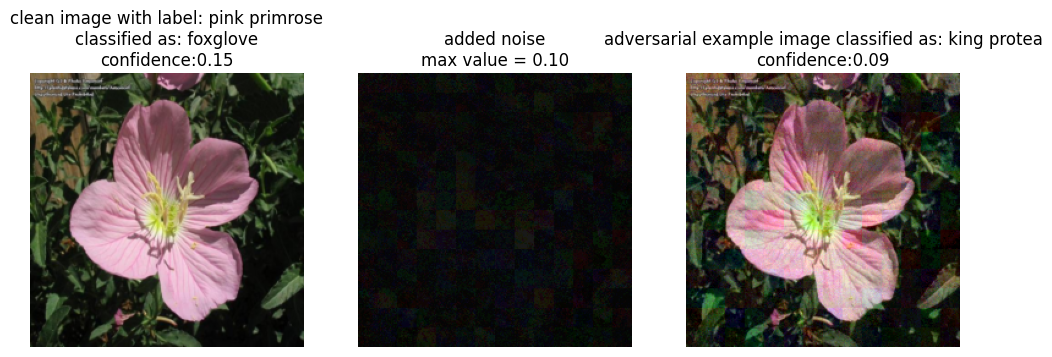

In [ ]:
attack_args['model'] = vit
plot_adversarial_example(valloader, vit,flowers102_class_names,flowers_mean,flowers_std, device)

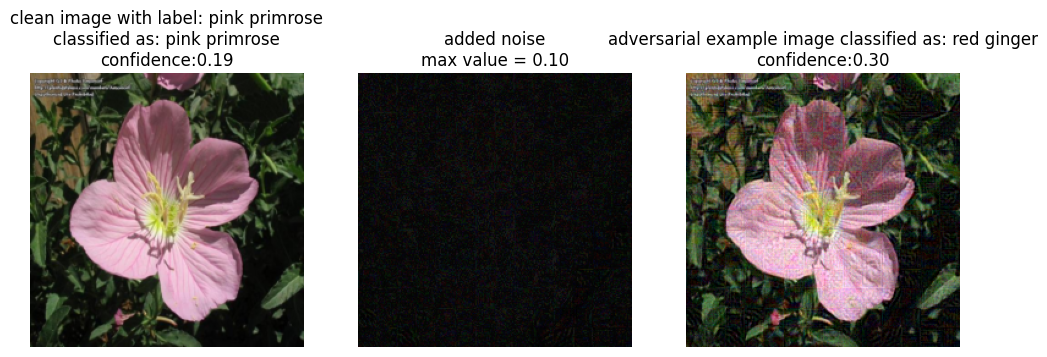

In [ ]:
attack_args['model'] = pretrained_vit
plot_adversarial_example(valloader, pretrained_vit,flowers102_class_names,flowers_mean,flowers_std, device)

In [ ]:
trainvalloader.set_attack_mode()
trainloader.set_attack_mode()
valloader.set_attack_mode()
testloader.set_attack_mode()

In [ ]:
y_pred = []
y_true = []
model_names = ['Fully Trained ViT PGD attacked','Pretrained ViT PGD attacked']

attack_args['model'] = vit
pred, true = get_predictions(vit,valloader,device)
y_pred.append(pred)
y_true.append(true)

attack_args['model'] = pretrained_vit
pred, true = get_predictions(pretrained_vit,valloader,device)
y_pred.append(pred)
y_true.append(true)

scores = evaluate(y_pred,y_true,model_names, class_names=flowers102_class_names)
scores

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Fully Trained ViT PGD attacked  Pretrained ViT PGD attacked
Accuracy                         0.038235                          0.0
Precision                        0.031034                          0.0
Recall                           0.038235                          0.0
F1 score                         0.026913                          0.0

In [ ]:
epochs = 10
lr = 1e-3

attack_args['model'] = vit
optimizer = torch.optim.Adam(vit.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

hist = train(vit, trainloader, valloader, criterion, optimizer, epochs, device)

plot_history(hist,'Adversarially Trained ViT')

In [ ]:
epochs = 10
lr = 1e-3

attack_args['model'] = pretrained_vit
optimizer = torch.optim.Adam(pretrained_vit.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

hist = train(pretrained_vit, trainloader, valloader, criterion, optimizer, epochs, device)

plot_history(hist,'Adversarially Trained Pretrained ViT')

In [ ]:
y_pred = []
y_true = []
model_names = ['ViT PGD attacked','Pretrained ViT PGD attacked', 'ViT clean','Pretrained ViT clean']

attack_args['model'] = vit
pred, true = get_predictions(vit,valloader,device)
y_pred.append(pred)
y_true.append(true)

attack_args['model'] = pretrained_vit
pred, true = get_predictions(pretrained_vit,valloader,device)
y_pred.append(pred)
y_true.append(true)

trainvalloader.set_clean_mode()
trainloader.set_clean_mode()
valloader.set_clean_mode()
testloader.set_clean_mode()

pred, true = get_predictions(vit,valloader,device)
y_pred.append(pred)
y_true.append(true)

pred, true = get_predictions(pretrained_vit,valloader,device)
y_pred.append(pred)
y_true.append(true)

scores = evaluate(y_pred,y_true,model_names, class_names=flowers102_class_names)
scores

# <a id='toc8_'></a>[Evaluate on Testset](#toc0_)

## <a id='toc8_1_'></a>[ResNet](#toc0_)

In [ ]:
attack = fgsm_attack
attack_args = {'epsilon': 0.1,
              'alpha': 0.02,
              'steps': 7,}

restrainset.set_transform(cifar_transform)
restestset.set_transform(cifar_transform)

batch_size=64
trainloader = AdversarialDataLoader(restrainset, batch_size=batch_size, shuffle=False, num_workers=2,
                                 attack=attack,mean=cifar_mean,std=cifar_std,device=device,attack_args=attack_args)
testloader = AdversarialDataLoader(restestset, batch_size=batch_size, shuffle=False, num_workers=2,
                                  attack=attack,mean=cifar_mean,std=cifar_std,device=device,attack_args=attack_args)
testloader_pgd = AdversarialDataLoader(restestset, batch_size=batch_size, shuffle=False, num_workers=2,
                                  attack=pgd_attack,mean=cifar_mean,std=cifar_std,device=device,attack_args=attack_args)

trainloader.set_attack_mode()
testloader.set_attack_mode()
testloader_pgd.set_attack_mode()

In [ ]:
epochs = 10
lr = 1e-3

resnet18 = create_resnet18_model(100)
resnet18.load_state_dict(torch.load('resnet18.pth'))

attack_args['model'] = resnet18
optimizer = torch.optim.Adam(resnet18.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train(resnet18, trainloader, testloader, criterion, optimizer, epochs, device,False)

state_dict = resnet18.state_dict()
torch.save(state_dict, 'test_resnet18.pth')

Epoch [1] Average Training Loss: 5.6746 Average Training Accuracy: 0.0339
Epoch [2] Average Training Loss: 4.1370 Average Training Accuracy: 0.0664
Epoch [3] Average Training Loss: 3.6074 Average Training Accuracy: 0.1379
Epoch [4] Average Training Loss: 2.6821 Average Training Accuracy: 0.3044
Epoch [5] Average Training Loss: 1.8588 Average Training Accuracy: 0.4965
Epoch [6] Average Training Loss: 1.0781 Average Training Accuracy: 0.7167
Epoch [7] Average Training Loss: 0.3505 Average Training Accuracy: 0.9254
Epoch [8] Average Training Loss: 0.1458 Average Training Accuracy: 0.9789
Epoch [9] Average Training Loss: 0.0894 Average Training Accuracy: 0.9898
Epoch [10] Average Training Loss: 0.0435 Average Training Accuracy: 0.9964


In [ ]:
untrained_resnet18 = create_resnet18_model(100)
untrained_resnet18.load_state_dict(torch.load('resnet18.pth'))

<All keys matched successfully>

In [ ]:
y_pred = []
y_true = []
models = [untrained_resnet18,resnet18]
model_names = ['ResNet18 clean', 'ResNet18 FGSM', 'ResNet18 PGD', 'Adv. Trained ResNet18 clean', 'Adv. Trained ResNet18 FGSM', 'Adv. Trained ResNet18 PGD']

for model in models:
    testloader.set_clean_mode()
    attack_args['model'] = model
    pred, true = get_predictions(model,testloader,device)
    y_pred.append(pred)
    y_true.append(true)

    testloader.set_attack_mode()
    attack_args['model'] = model
    pred, true = get_predictions(model,testloader,device)
    y_pred.append(pred)
    y_true.append(true)

    attack_args['model'] = model
    pred, true = get_predictions(model,testloader_pgd,device)
    y_pred.append(pred)
    y_true.append(true)

scores = evaluate(y_pred,y_true,model_names, class_names=cifar100_class_names)
scores

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

ResNet18 clean  ResNet18 FGSM  ResNet18 PGD  \
Accuracy         0.344700       0.000100      0.003100   
Precision        0.357221       0.000015      0.020771   
Recall           0.344700       0.000100      0.003100   
F1 score         0.343314       0.000026      0.003660   

           Adv. Trained ResNet18 clean  Adv. Trained ResNet18 FGSM  \
Accuracy                      0.216600                    0.679000   
Precision                     0.284339                    0.707474   
Recall                        0.216600                    0.679000   
F1 score                      0.201453                    0.681201   

           Adv. Trained ResNet18 PGD  
Accuracy                    0.236100  
Precision                   0.255180  
Recall                      0.236100  
F1 score                    0.231877

**With noise**

In [ ]:
epochs = 10
lr = 1e-3
testloader.set_attack_mode()

noisy_resnet18 = create_resnet18_model(100)
noisy_resnet18.load_state_dict(torch.load('noisy_resnet18.pth'))

attack_args['model'] = noisy_resnet18
optimizer = torch.optim.Adam(noisy_resnet18.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train(noisy_resnet18, trainloader, testloader, criterion, optimizer, epochs, device,False)

state_dict = noisy_resnet18.state_dict()
torch.save(state_dict, 'test_noisy_resnet18.pth')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1] Average Training Loss: 5.7383 Average Training Accuracy: 0.0286
Epoch [2] Average Training Loss: 4.4507 Average Training Accuracy: 0.0336
Epoch [3] Average Training Loss: 4.3873 Average Training Accuracy: 0.0415
Epoch [4] Average Training Loss: 4.3382 Average Training Accuracy: 0.0464
Epoch [5] Average Training Loss: 4.2938 Average Training Accuracy: 0.0512
Epoch [6] Average Training Loss: 4.1795 Average Training Accuracy: 0.0646
Epoch [7] Average Training Loss: 3.5048 Average Training Accuracy: 0.1537
Epoch [8] Average Training Loss: 2.7858 Average Training Accuracy: 0.2961
Epoch [9] Average Training Loss: 1.8891 Average Training Accuracy: 0.5118
Epoch [10] Average Training Loss: 0.6271 Average Training Accuracy: 0.8446


In [ ]:
untrained_resnet18 = create_resnet18_model(100)
untrained_resnet18.load_state_dict(torch.load('noisy_resnet18.pth'))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
y_pred = []
y_true = []
models = [untrained_resnet18,noisy_resnet18]
model_names = ['ResNet18 clean', 'ResNet18 FGSM', 'ResNet18 PGD', 'Adv. Trained ResNet18 clean', 'Adv. Trained ResNet18 FGSM', 'Adv. Trained ResNet18 PGD']

for model in models:
    testloader.set_clean_mode()
    attack_args['model'] = model
    pred, true = get_predictions(model,testloader,device)
    y_pred.append(pred)
    y_true.append(true)

    testloader.set_attack_mode()
    attack_args['model'] = model
    pred, true = get_predictions(model,testloader,device)
    y_pred.append(pred)
    y_true.append(true)

    attack_args['model'] = model
    pred, true = get_predictions(model,testloader_pgd,device)
    y_pred.append(pred)
    y_true.append(true)

scores = evaluate(y_pred,y_true,model_names, class_names=cifar100_class_names)
scores

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ResNet18 clean  ResNet18 FGSM  ResNet18 PGD  \
Accuracy         0.328500       0.000100      0.005800   
Precision        0.358352       0.000175      0.010510   
Recall           0.328500       0.000100      0.005800   
F1 score         0.326437       0.000127      0.005624   

           Adv. Trained ResNet18 clean  Adv. Trained ResNet18 FGSM  \
Accuracy                      0.239300                    0.552300   
Precision                     0.309517                    0.655053   
Recall                        0.239300                    0.552300   
F1 score                      0.231043                    0.560275   

           Adv. Trained ResNet18 PGD  
Accuracy                    0.074000  
Precision                   0.107162  
Recall                      0.074000  
F1 score                    0.073782

## <a id='toc8_2_'></a>[ViT](#toc0_)

In [ ]:
attack = fgsm_attack
attack_args = {'epsilon': 0.1,
              'alpha': 0.02,
              'steps': 7,}

vittrainset.set_transform(flowers_transform)
vittestset.set_transform(flowers_transform)

batch_size=64
trainloader = AdversarialDataLoader(vittrainset, batch_size=batch_size, shuffle=False, num_workers=2,
                                 attack=attack,mean=flowers_mean,std=flowers_std,device=device,attack_args=attack_args)
testloader = AdversarialDataLoader(vittestset, batch_size=batch_size, shuffle=False, num_workers=2,
                                  attack=attack,mean=flowers_mean,std=flowers_std,device=device,attack_args=attack_args)
testloader_pgd = AdversarialDataLoader(vittestset, batch_size=batch_size, shuffle=False, num_workers=2,
                                  attack=pgd_attack,mean=flowers_mean,std=flowers_std,device=device,attack_args=attack_args)

trainloader.set_attack_mode()
testloader.set_attack_mode()
testloader_pgd.set_attack_mode()

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 150MB/s]


Epoch [1] Average Training Loss: 5.4087 Average Training Accuracy: 0.0127
Epoch [1] Average Validation Loss: 5.1579 Average Validation Accuracy: 0.0208
Epoch [2] Average Training Loss: 4.1343 Average Training Accuracy: 0.0775
Epoch [2] Average Validation Loss: 4.6335 Average Validation Accuracy: 0.0481
Epoch [3] Average Training Loss: 3.6883 Average Training Accuracy: 0.1637
Epoch [3] Average Validation Loss: 4.4043 Average Validation Accuracy: 0.0673
Epoch [4] Average Training Loss: 3.4318 Average Training Accuracy: 0.2196
Epoch [4] Average Validation Loss: 4.2938 Average Validation Accuracy: 0.0877
Epoch [5] Average Training Loss: 3.1968 Average Training Accuracy: 0.2882
Epoch [5] Average Validation Loss: 4.2306 Average Validation Accuracy: 0.0973
Epoch [6] Average Training Loss: 2.9931 Average Training Accuracy: 0.3608
Epoch [6] Average Validation Loss: 4.1834 Average Validation Accuracy: 0.1067
Epoch [7] Average Training Loss: 2.8193 Average Training Accuracy: 0.4216
Epoch [7] Aver

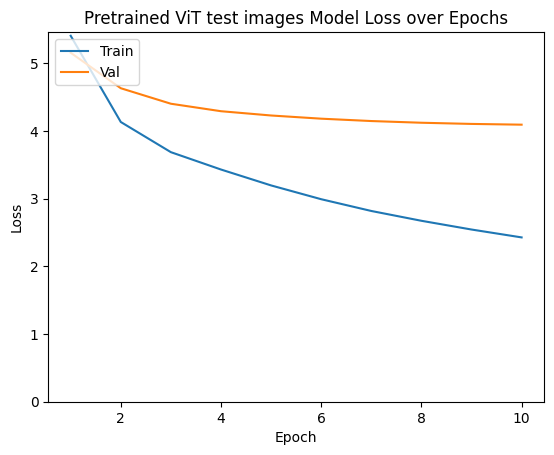

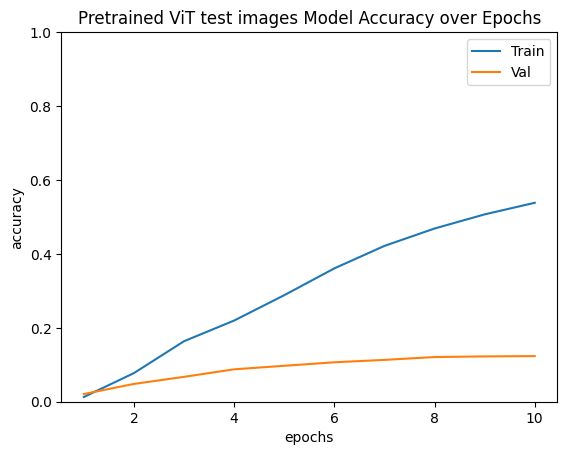

In [ ]:
epochs = 10
lr = 1e-3

pretrained_vit = create_vit_model(102,True)
pretrained_vit.load_state_dict(torch.load('pretrained_vit.pth'))

attack_args['model'] = pretrained_vit
optimizer = torch.optim.Adam(pretrained_vit.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

hist = train(pretrained_vit, trainloader, testloader, criterion, optimizer, epochs, device)
plot_history(hist,'Pretrained ViT test images')

state_dict = pretrained_vit.state_dict()
torch.save(state_dict, 'test_pretrained_vit.pth')

In [ ]:
untrained_vit = create_vit_model(102,True)
untrained_vit.load_state_dict(torch.load('pretrained_vit.pth'))

<All keys matched successfully>

In [ ]:
y_pred = []
y_true = []
models = [untrained_vit,pretrained_vit]
model_names = ['Pre. ViT clean', 'Pre. ViT FGSM', 'Pre. ViT PGD', 'Adv. Trained Pre. ViT clean', 'Adv. Trained Pre. ViT FGSM', 'Adv. Trained Pre. ViT PGD']

for model in models:
    testloader.set_clean_mode()
    attack_args['model'] = model
    pred, true = get_predictions(model,testloader,device)
    y_pred.append(pred)
    y_true.append(true)

    testloader.set_attack_mode()
    attack_args['model'] = model
    pred, true = get_predictions(model,testloader,device)
    y_pred.append(pred)
    y_true.append(true)

    attack_args['model'] = model
    pred, true = get_predictions(model,testloader_pgd,device)
    y_pred.append(pred)
    y_true.append(true)

scores = evaluate(y_pred,y_true,model_names, class_names=flowers102_class_names)
scores

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Pre. ViT clean  Pre. ViT FGSM  Pre. ViT PGD  \
Accuracy         0.773134       0.015450           0.0   
Precision        0.796548       0.015152           0.0   
Recall           0.773134       0.015450           0.0   
F1 score         0.772948       0.009697           0.0   

           Adv. Trained Pre. ViT clean  Adv. Trained Pre. ViT FGSM  \
Accuracy                      0.651000                    0.123435   
Precision                     0.772205                    0.122842   
Recall                        0.651000                    0.123435   
F1 score                      0.636151                    0.106604   

           Adv. Trained Pre. ViT PGD  
Accuracy                         0.0  
Precision                        0.0  
Recall                           0.0  
F1 score                         0.0

In [ ]:
epochs = 10
lr = 1e-3

vit = create_vit_model(102,False)
vit.load_state_dict(torch.load('vit.pth'))

attack_args['model'] = vit
optimizer = torch.optim.Adam(vit.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train(vit, trainloader, testloader, criterion, optimizer, epochs, device,False)

state_dict = vit.state_dict()
torch.save(state_dict, 'test_vit.pth')

Epoch [1] Average Training Loss: 6.3723 Average Training Accuracy: 0.0088
Epoch [2] Average Training Loss: 6.2024 Average Training Accuracy: 0.0000
Epoch [3] Average Training Loss: 5.3481 Average Training Accuracy: 0.0000
Epoch [4] Average Training Loss: 5.0261 Average Training Accuracy: 0.0000
Epoch [5] Average Training Loss: 4.9554 Average Training Accuracy: 0.0000
Epoch [6] Average Training Loss: 4.9219 Average Training Accuracy: 0.0000
Epoch [7] Average Training Loss: 4.8818 Average Training Accuracy: 0.0000
Epoch [8] Average Training Loss: 4.7880 Average Training Accuracy: 0.0000
Epoch [9] Average Training Loss: 4.7097 Average Training Accuracy: 0.0000
Epoch [10] Average Training Loss: 4.6354 Average Training Accuracy: 0.0078


In [ ]:
untrained_vit = create_vit_model(102,False)
untrained_vit.load_state_dict(torch.load('vit.pth'))

<All keys matched successfully>

In [ ]:
y_pred = []
y_true = []
models = [untrained_vit,vit]
model_names = ['ViT clean', 'ViT FGSM', 'ViT PGD', 'Adv. Trained ViT clean', 'Adv. Trained ViT FGSM', 'Adv. Trained ViT PGD']

for model in models:
    testloader.set_clean_mode()
    attack_args['model'] = model
    pred, true = get_predictions(model,testloader,device)
    y_pred.append(pred)
    y_true.append(true)

    testloader.set_attack_mode()
    attack_args['model'] = model
    pred, true = get_predictions(model,testloader,device)
    y_pred.append(pred)
    y_true.append(true)

    attack_args['model'] = model
    pred, true = get_predictions(model,testloader_pgd,device)
    y_pred.append(pred)
    y_true.append(true)

scores = evaluate(y_pred,y_true,model_names, class_names=flowers102_class_names)
scores

# <a id='toc9_'></a>[Grad-CAM](#toc0_)

In [ ]:
def get_grad_cam(model,layer,image,mean,std, label,reshape_transform):
  model.eval()
  cam = GradCAM(model=model, target_layers=[layer],reshape_transform=reshape_transform)
  image = image.unsqueeze(0).to(device)

  output = model(image)
  pred_class = output.argmax().item()

  grayscale_cam = cam(input_tensor=image, targets=[ClassifierOutputTarget(label.item())])[0]

  image = (image * std) + mean
  img_np = image.squeeze(0).cpu().permute(1, 2, 0).numpy()
  img_np = img_np.clip(0, 1)

  return show_cam_on_image(img_np, grayscale_cam, use_rgb=True),pred_class

## <a id='toc9_1_'></a>[ResNet](#toc0_)

In [ ]:
def plot_image(plt, idx, image, model_name, image_name,class_names,pred,row=5,height=3):
    plt.subplot(row,height,idx)
    plt.imshow(image)
    plt.title(model_name+'\nClassified as:'+class_names[pred]+'\n'+image_name)
    plt.axis('off')

def plot_grad_cams(model, start_idx, layer, mean, std, model_name, class_names, attack_args, testloader, testloader_pgd,data_idx=0,reshape_transform=None):
  attack_args['model'] = model

  testloader.set_both_mode()
  dataiter = iter(testloader)
  testloader_pgd.set_attack_mode()
  dataiter_pgd = iter(testloader_pgd)

  images, fgsms, labels = next(dataiter)
  pgds, labels = next(dataiter_pgd)

  image = images[data_idx]
  fgsm = fgsms[data_idx]
  pgd = pgds[data_idx]
  label = labels[data_idx]

  res_image,pred = get_grad_cam(model,layer,image,mean,std,label,reshape_transform)
  plot_image(plt,start_idx,res_image,model_name,'Clean',class_names,pred)

  res_fgsm,pred = get_grad_cam(model,layer,fgsm,mean,std,label,reshape_transform)
  plot_image(plt,start_idx+1,res_fgsm,model_name,'FGSM',class_names,pred)

  res_pgd,pred = get_grad_cam(model,layer,pgd,mean,std,label,reshape_transform)
  plot_image(plt,start_idx+2,res_pgd,model_name,'PGD',class_names,pred)

In [ ]:
resnet18 = create_resnet18_model(100)
resnet18.load_state_dict(torch.load('test_resnet18.pth'))
noisy_resnet18 = create_resnet18_model(100)
noisy_resnet18.load_state_dict(torch.load('test_noisy_resnet18.pth'))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<Figure size 900x1800 with 0 Axes>

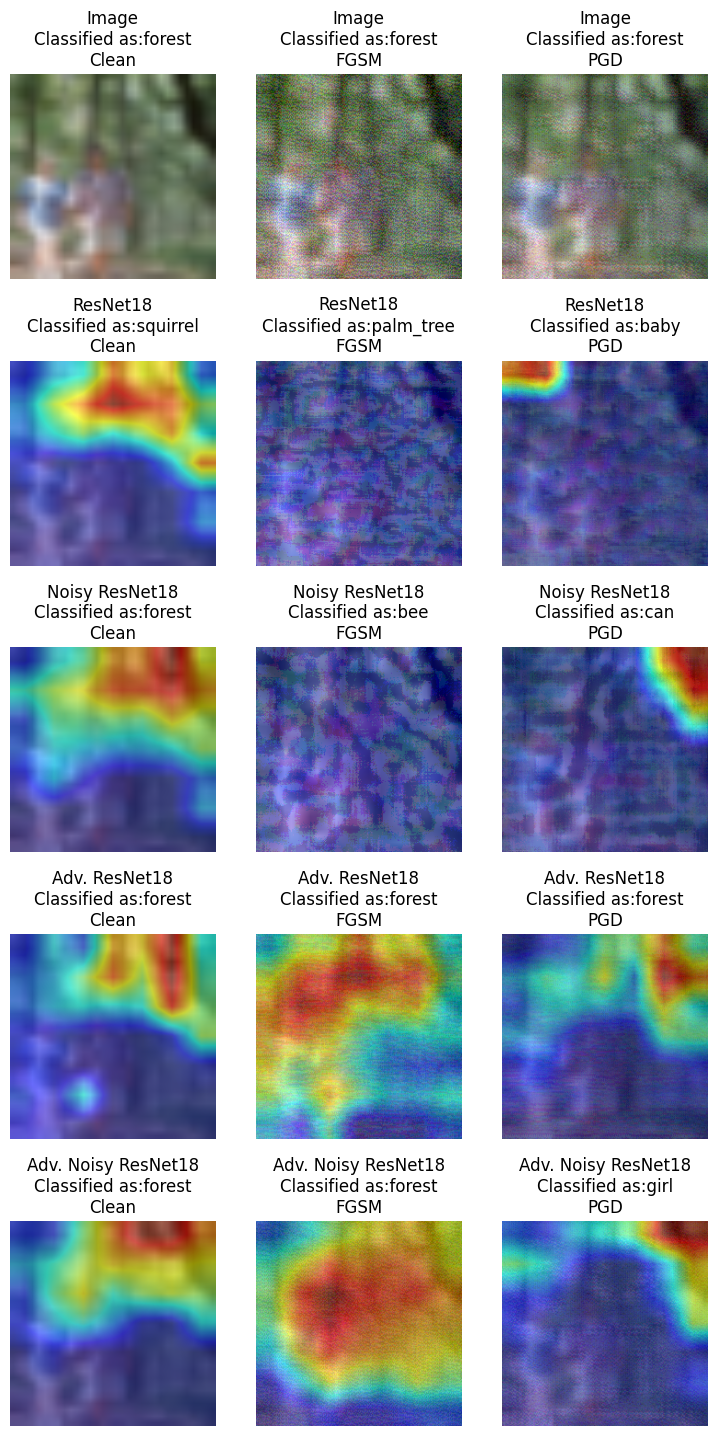

In [ ]:
testloader.set_both_mode()
dataiter = iter(testloader)
testloader_pgd.set_attack_mode()
dataiter_pgd = iter(testloader_pgd)

attack_args['model'] = resnet18
images, fgsms, labels = next(dataiter)
pgds, labels = next(dataiter_pgd)

mean = cifar_mean.to(device)
std = cifar_std.to(device)

names = cifar100_class_names
plt.figure(figsize=(9,18))

idx = 1
image = images[idx]
fgsm = fgsms[idx]
pgd = pgds[idx]
label = labels[idx]

names = cifar100_class_names
plt.figure(figsize=(9,18))

unscaled_img = (image * std + mean).clip(0, 1)
unscaled_fgsm = (fgsm * std + mean).clip(0, 1)
unscaled_pgd = (pgd * std + mean).clip(0, 1)

unscaled_img = unscaled_img.cpu().numpy()
unscaled_fgsm = unscaled_fgsm.cpu().numpy()
unscaled_pgd = unscaled_pgd.cpu().numpy()

plot_image(plt,1,np.transpose(unscaled_img, (1, 2, 0)),'Image','Clean',names,label)
plot_image(plt,2,np.transpose(unscaled_fgsm, (1, 2, 0)),'Image','FGSM',names,label)
plot_image(plt,3,np.transpose(unscaled_pgd, (1, 2, 0)),'Image','PGD',names,label)

untrained_resnet18 = create_resnet18_model(100)
untrained_resnet18.load_state_dict(torch.load('resnet18.pth'))
layer = untrained_resnet18.layer4[-1]
plot_grad_cams(untrained_resnet18, 4, layer, mean, std, 'ResNet18', names, attack_args, testloader, testloader_pgd,idx)

untrained_resnet18 = create_resnet18_model(100)
untrained_resnet18.load_state_dict(torch.load('noisy_resnet18.pth'))
layer = untrained_resnet18.layer4[-1]
plot_grad_cams(untrained_resnet18, 7, layer, mean, std, 'Noisy ResNet18', names, attack_args, testloader, testloader_pgd,idx)

layer = resnet18.layer4[-1]
plot_grad_cams(resnet18, 10, layer, mean, std, 'Adv. ResNet18', names, attack_args, testloader, testloader_pgd,idx)

layer = noisy_resnet18.layer4[-1]
plot_grad_cams(noisy_resnet18, 13, layer, mean, std, 'Adv. Noisy ResNet18', names, attack_args, testloader, testloader_pgd,idx)

## <a id='toc9_2_'></a>[ViT](#toc0_)

In [ ]:
vit = create_vit_model(102,False)
vit.load_state_dict(torch.load('test_vit.pth'))

<All keys matched successfully>

In [ ]:
pretrained_vit = create_vit_model(102,True)
pretrained_vit.load_state_dict(torch.load('test_pretrained_vit.pth'))

<All keys matched successfully>

In [ ]:
def vit_reshape_transform(tensor):
    if tensor.ndim == 3 and tensor.shape[1] > 1:
        tensor = tensor[:, 1:, :]

    batch_size, num_patches, embedding_dim = tensor.shape

    grid_size = int(num_patches**0.5)
    tensor = tensor.reshape(batch_size, grid_size, grid_size, embedding_dim)
    tensor = tensor.permute(0, 3, 1, 2)
    return tensor

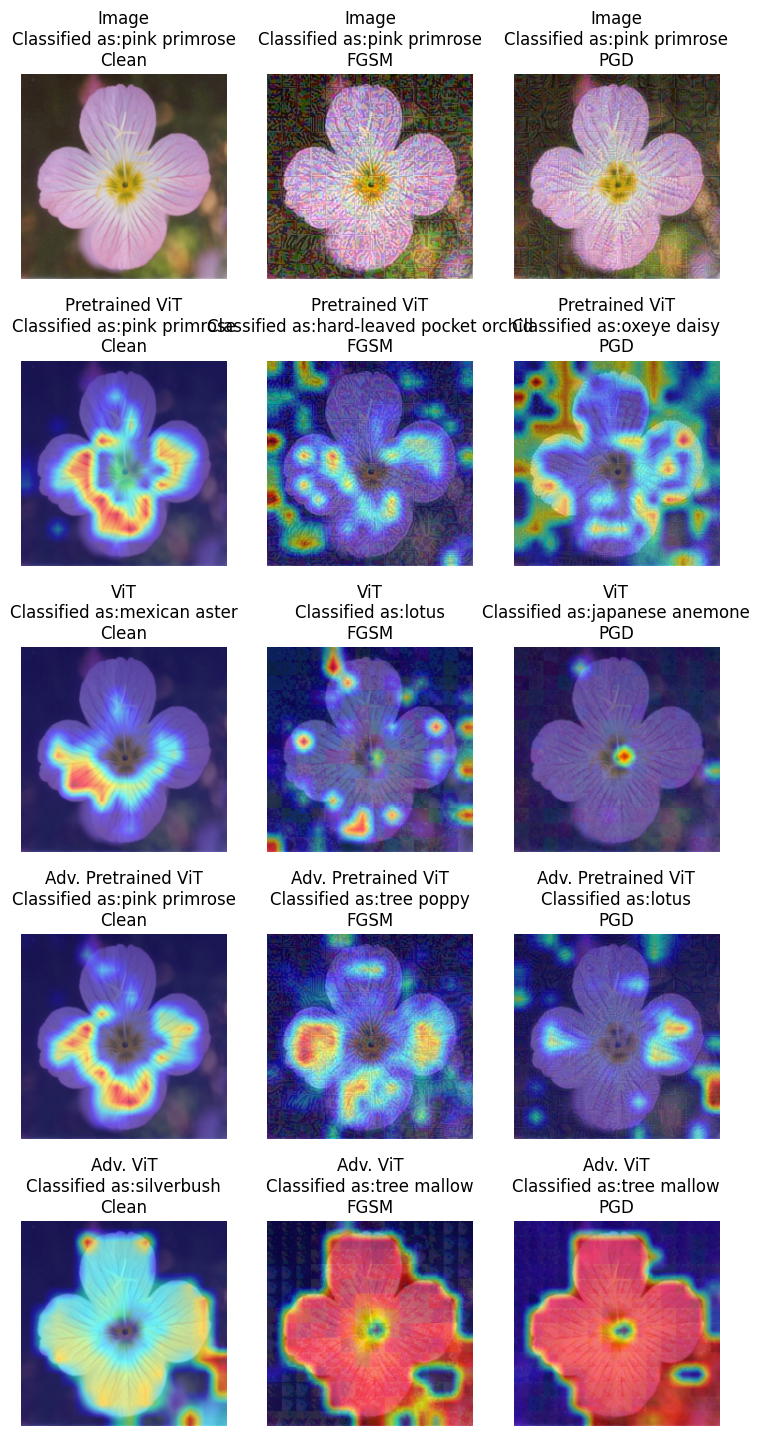

In [ ]:
testloader.set_both_mode()
dataiter = iter(testloader)
testloader_pgd.set_attack_mode()
dataiter_pgd = iter(testloader_pgd)

mean = flowers_mean.to(device)
std = flowers_std.to(device)

names = flowers102_class_names
plt.figure(figsize=(9,18))

attack_args['model'] = pretrained_vit
images, fgsms, labels = next(dataiter)
pgds, labels = next(dataiter_pgd)

idx = 7
image = images[idx]
fgsm = fgsms[idx]
pgd = pgds[idx]
label = labels[idx]

unscaled_img = (image * std + mean).clip(0, 1)
unscaled_fgsm = (fgsm * std + mean).clip(0, 1)
unscaled_pgd = (pgd * std + mean).clip(0, 1)

unscaled_img = unscaled_img.cpu().numpy()
unscaled_fgsm = unscaled_fgsm.cpu().numpy()
unscaled_pgd = unscaled_pgd.cpu().numpy()

plot_image(plt,1,np.transpose(unscaled_img, (1, 2, 0)),'Image','Clean',names,label)
plot_image(plt,2,np.transpose(unscaled_fgsm, (1, 2, 0)),'Image','FGSM',names,label)
plot_image(plt,3,np.transpose(unscaled_pgd, (1, 2, 0)),'Image','PGD',names,label)

untrained_vit = create_vit_model(102,True)
untrained_vit.load_state_dict(torch.load('pretrained_vit.pth'))
for param in untrained_vit.parameters():
    param.requires_grad = True
layer = untrained_vit.encoder.layers[-1].ln_1
plot_grad_cams(untrained_vit, 4, layer, mean, std, 'Pretrained ViT', names, attack_args, testloader, testloader_pgd,idx,vit_reshape_transform)

untrained_vit = create_vit_model(102,False)
untrained_vit.load_state_dict(torch.load('vit.pth'))
layer = untrained_vit.encoder.layers[-1].ln_1
plot_grad_cams(untrained_vit, 7, layer, mean, std, 'ViT', names, attack_args, testloader, testloader_pgd,idx,vit_reshape_transform)

for param in pretrained_vit.parameters():
    param.requires_grad = True
layer = pretrained_vit.encoder.layers[-1].ln_1
plot_grad_cams(pretrained_vit, 10, layer, mean, std, 'Adv. Pretrained ViT', names, attack_args, testloader, testloader_pgd,idx,vit_reshape_transform)

layer = vit.encoder.layers[-1].ln_1
plot_grad_cams(vit, 13, layer, mean, std, 'Adv. ViT', names, attack_args, testloader, testloader_pgd,idx,vit_reshape_transform)